# Crowded field photometry --- 1a. NIRISS imaging & WFSS simulation

This notebook demonstrates how to create JWST data by using [MIRAGE](https://mirage-data-simulator.readthedocs.io/en/latest/).
This is one of series of notebooks that focus on crwoded field photometry (see other notebooks in the directory).


This notebook will demonstrate how to create NIRISS WFSS and direct image simulation. It will require the following input files;
1. APT output files (.xml and .pointing) that specify the observation
2. A source catalog that lists source properties (magnitude/morphology...), taken from HST.

Users may also provide their catalog/apt files, to create own scenes, but may need to allocate columns for physical parameters.


## To Do:
- 1.Read input catalogs
- 2.Generate two Mirage friendly source catalogs (one for point source, and the other for extended).
- 3.Generate a set of yaml files, setup files for Mirage.
- 4.Run simulation for NIRISS direct images and WFSS.

*Reduction of these generated raw data will be demonstrated in another notebook.

### Requirement:
- Mirage environment. [see here](https://mirage-data-simulator.readthedocs.io/en/latest/install.html)

In [1]:
%matplotlib inline

In [2]:
# Set environment variables
# It may be helpful to set these within your .bashrc or .cshrc file, so that CRDS will
# know where to look for reference files during future runs of the JWST calibration
# pipeline.

import os
os.environ["MIRAGE_DATA"] = "/ifs/jwst/wit/mirage_data/"
os.environ["CRDS_PATH"] = os.path.join(os.path.expandvars('$HOME'), "crds_cache")
os.environ["CDRS_SERVER_URL"]="https://jwst-cdrs.stsci.edu"

In [3]:
from glob import glob
import pkg_resources
import yaml

from astropy.io import fits
import astropy.units as u
from astropy.visualization import simple_norm, imshow_norm
import h5py
import numpy as np
import matplotlib.pyplot as plt

from mirage import imaging_simulator
from mirage import wfss_simulator
from mirage.utils.constants import FLAMBDA_CGS_UNITS, FLAMBDA_MKS_UNITS, FNU_CGS_UNITS 
from mirage.yaml import yaml_generator

/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/pysynphot/locations.py:47: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [4]:
import mirage
import astropy

print(mirage.__version__)
print(astropy.__version__)

1.2.3.dev10+geb23408
4.0


---
<a id='yaml_from_apt'></a>
## Create a series of yaml files from [APT](https://jwst-docs.stsci.edu/display/JPP/JWST+Astronomers+Proposal+Tool+Overview)

To set Mirage up for your observation designed in APT, you need to get .xml and .pointing files out of your APT file and provide them to Mirage.
You can get these files from APT's tool bar ([File]->[Export]).

As an example, observation here is taken from [GLASS-ERS](http://www.stsci.edu/jwst/observing-programs/approved-ers-programs/program-1324)

In [6]:
# Input files from APT
# These can be obtained from a tab, [File]->[Export], in APT.
# There is some modification:
# 1.Deep direct imaging (3600s per exposure), so you can see simulated sources
# 2.Cut out NIRSPEC observations; otherwise, Mirage would crash as it does not recognize NIRSPEC observation.
xml_file      = './A2744_example_nis.xml' 
pointing_file = './A2744_example_nis.pointing'

In [7]:
# These following are some misc params.

# Set reference file values. 
# Setting to 'crds_full_name' will search for and download needed
# calibration reference files (commonly referred to as CRDS reference files) when
# the yaml_generator is run. 
# 
# Setting to 'crds' will put placeholders in the yaml files and save the downloading
# for when the simulated images are created.
reffile_defaults = 'crds'

# Optionally set the cosmic ray library and rate
cosmic_rays = {'library': 'SUNMAX', 'scale': 1.0}

# Optionally set the observation date to use for the data. Note that this information
# is placed in the headers of the output files, but not used by Mirage in any way.
dates = '2022-07-01'

In [8]:
# Optionally set the background signal rates to be used
# As in Cami's note, this may not work.
background = 'low' # 'medium', 'high', or 0.

In [9]:
# Optionally set the telescope roll angle (PAV3) for the observations
# This can be checked in APT's Aladin function.
pav3 = 230 #12.5 + 45.

You can specify the data reduction state of the Mirage outputs.
Options are 'raw', 'linear', or 'linear, raw'. 

If 'raw' is specified, the output is a completely uncalibrated file, with a filename ending in "uncal.fits"

If 'linear' is specified, the output is a file with linearized signals, ending in "linear.fits". This is equivalent to having been run through the dq_init, saturation flagging, superbias subtraction, reference pixel subtraction, and non-linearity correction steps of the calibration pipeline. Note that this product does not include dark current subtraction.

If 'linear, raw', both outputs are saved.

In order to fully process the Mirage output with the default steps used by the pipeline, it would be best to use the 'raw' output and run the entire calibration pipeline.

In [10]:
datatype = 'raw' # 'linear, raw'

## 1.Make a catalog based on a real field. 

Here we use a set of catalogs from Morishita et al. (2016), on Hubble Frontier Fields cluster, Abell2744.
Catalogs are located in the current directory.

- input_01.cat : Flux catalog for 7 HST filters. We will use some of them to provide source fluxes to Mirage.
- f160w_01.cat : SExtractor catalog for the same targets. We will use morphological parameters.

Users may also provide their own catalogs.

In [13]:
# Read the original catalog;

# Target ID for the field;
FLD    = 'abell2744clu'
FLDID  = '01'

# Input catalog for flux infos
input_phot = './input_%s.cat'%(FLDID)
mag0       = 25.0 # Magnitude zeropoint of the flux.

In [14]:
from astropy.io import ascii
t = ascii.read(input_phot)
t

id,F202,E202,F203,E203,F204,E204,F205,E205,F1,E1,F4,E4,F6,E6,z_spec
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,0.624986,0.0203839,0.592951,17563800000.0,0.656564,0.029636,0.626751,0.0282937,0.170542,0.00989201,0.359137,0.00907408,0.522035,0.0082052,-1.0
2,314.114,12.5866,340.324,16.549,-105.725,15.3392,320.083,15.138,42.9727,9.0398,127.168,8.52269,191.15,7.92587,-1.0
3,0.736321,0.0664238,0.713252,0.0773986,0.956011,0.083933,0.882391,0.0848865,-0.00191998,0.0419397,0.153394,0.039261,0.223664,0.0369563,-1.0
4,0.907819,0.0384802,1.05968,0.0522367,1.02077,0.0463675,1.16958,0.0458873,0.0242561,0.0310793,0.335871,0.0292072,0.659421,0.0272263,-1.0
5,0.0625458,0.01384,0.120584,0.0179007,0.0985083,0.0165368,0.112902,0.0166103,0.00953505,0.0153957,0.017454,0.014449,0.0732586,0.0134916,-1.0
6,0.121161,0.00941203,0.124111,0.011886,0.101029,0.0114383,0.124934,0.0114686,-0.00330664,0.0091876,0.0202073,0.0086549,0.105672,0.00806936,-1.0
7,0.288925,0.0391671,0.433598,0.0528055,0.427743,0.0467582,0.540242,0.0467235,0.17582,0.0454997,0.168246,0.0423119,0.452225,0.0398403,-1.0
8,1.2405,0.0187341,1.41774,0.0253482,1.38384,0.0226298,1.50196,0.0222643,0.134416,0.0274284,0.494508,0.0247042,0.872047,0.0254846,-1.0
9,2.10599,0.137787,2.16932,0.169519,2.48515,0.169253,2.55756,0.169606,1.41246,0.102024,0.955905,0.0945733,1.09973,0.0883537,-1.0


In [15]:
# Then, read Sextractor catalog;
pixscale = 0.06 # arcsec/pixel

input_sext = './f160w_%s.cat'%(FLDID)
ts         = ascii.read(input_sext)
ts

NUMBER,MAG_AUTO,MAGERR_AUTO,KRON_RADIUS,BACKGROUND,X_WORLD,Y_WORLD,X_IMAGE,Y_IMAGE,THETA_IMAGE,ELONGATION,A_IMAGE,CLASS_STAR,FLUX_RADIUS,FLUX_RADIUS_1,FLAGS,ISOAREA_IMAGE,FLUX_AUTO,FLUXERR_AUTO,FLUX_APER,FLUX_APER_1,FLUX_APER_2,FLUXERR_APER,FLUXERR_APER_1,FLUXERR_APER_2,FLUX_ISO,FLUXERR_ISO
,mag,mag,,ct,deg,deg,pix,pix,deg,,pix,,pix,pix,,pix2,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,25.5143,16311731200.0,3.3,0.0003593041,3.5995108569,-30.418083853,1834.569,1270.388,39.6,1.197,2.812,0.03,3.028,5.408,3,90,0.6227228,9353303000.0,0.351622,0.4526939,0.6032723,0.01113947,0.01477247,0.0274099,0.5485082,0.01757988
2,18.7438,760274368.0,11.41,0.0006244646,3.5732101549,-30.375764396,3195.625,3809.613,-75.3,1.471,5.313,0.0,37.174,46.926,0,257,318.0261,222640000000.0,0.116857,0.1718233,0.3254758,0.008386489,0.01059577,0.01549258,0.6721871,0.0246015
3,25.1428,74186629120.0,9.07,0.0006867686,3.5740779021,-30.375741474,3150.708,3810.991,-54.5,1.384,2.327,0.01,8.804,14.883,0,45,0.8767204,59890360000.0,0.06484967,0.09959909,0.1927213,0.009744838,0.01231254,0.01865983,0.08543993,0.01103451
4,24.8369,0.0535,7.44,0.001195304,3.5747207745,-30.376125865,3117.429,3787.93,63.7,1.567,3.795,0.03,10.471,20.275,0,139,1.162064,0.05722248,0.1876889,0.2438105,0.3429625,0.007485226,0.009351618,0.01354294,0.4047972,0.01581401
5,27.3752,0.2837,7.75,0.0007567059,3.5772026652,-30.377140466,2988.954,3727.06,-19.5,1.87,2.882,0.0,3.429,5.835,3,47,0.1121761,0.02930624,0.04244092,0.05481424,0.06680619,0.005469979,0.006841388,0.009892243,0.05680151,0.006815003
6,28.7968,2.2292,7.5,0.0007625992,3.5770755235,-30.377017301,2995.536,3734.45,-20.3,1.784,5.368,0.0,1.094,1.619,3,106,0.03028963,0.06217462,0.06266458,0.08169081,0.1241311,0.006375726,0.007990558,0.01146856,0.1359485,0.01147924
7,25.6755,0.0986,8.05,0.0007589889,3.5770075322,-30.377261778,2999.054,3719.781,54.4,1.643,4.68,0.0,9.544,13.94,3,117,0.5367697,0.04874077,0.04674834,0.06447586,0.1090778,0.005258624,0.006594468,0.009494767,0.143235,0.01083641
8,24.5654,0.0289,4.15,0.0006050894,3.5743726173,-30.379483442,3135.435,3586.474,59.8,2.774,10.293,0.03,7.781,23.096,3,454,1.492308,0.03975435,0.3116273,0.4219823,0.6235535,0.005165731,0.006464446,0.009303004,1.221287,0.01946999


In [16]:
# Get morphology params;
idsext = ts['NUMBER']
radius = ts['FLUX_RADIUS']*pixscale # in arcsec
elong  = ts['ELONGATION'] # = a/b

pa         = 90. - ts['THETA_IMAGE'] # Theta_mirage = 90 - Theta_Sext
magauto    = ts['MAG_AUTO']
class_star = ts['CLASS_STAR']
ellip      = 1. - 1/elong

In [17]:
# Since the SExtractor catalog does not provide Sersic index;
# Set those bright, but extended object to n=4.
ser = radius * 0 + 1.0
con_ser = (magauto<20) & (class_star<0.9)
ser[con_ser] = 4.0

#### For now, just magnitude and source morphology are simulated.
#### One may also want to include redshift, to simulate SEDs for those not listed in the flux catalog.

In [18]:
# Then redshift information
# This is for redshift;
'''
input_eazy = './photz_%s.zout'%(FLDID)
ez = ascii.read(input_eazy)
ez
'''

"\ninput_eazy = './photz_%s.zout'%(FLDID)\nez = ascii.read(input_eazy)\nez\n"

In [19]:
# Primary infos;
id  = t['id']
ra  = ts['X_WORLD']
dec = ts['Y_WORLD']
#red = ez['z_m1']

In [20]:
# Manage flux column;
# This corresponds to photometric catalog;
filt  = ['F105W','F125W','F140W','F160W','F435W','F606W','F814W']
efilt = ['202','203','204','205','1','4','6'] # Corresponding column number in t.

flux = np.zeros((len(filt),len(id)),dtype='float32')
eflux= np.zeros((len(filt),len(id)),dtype='float32')
for ff in range(len(filt)):
    flux[ff,:]  = t['F%s'%(efilt[ff])]
    eflux[ff,:] = t['E%s'%(efilt[ff])]
    
mag160 = -2.5 * np.log10(flux[3,:]) + 25
mag160

array([25.507263, 18.736843, 25.135847, ..., 27.217876, 24.338139,
       26.0184  ], dtype=float32)

## 2.Write source properties in a catalog that is compatible with Mirage
Here, we are making a Mirage-friendly catalog out of the two table above.

For now, let's stick with a simple case, by pretending input magnitudes corresponds JWST magnitudes.
- HST F160W -> JWST F200W
- F140W -> F150W
- F105W -> F115W
- F814W -> F090W

One can also use ground-based K data for F200W, or SED fitting results extrapolated to F200W.

In [22]:
# Write into two files;
# 1. extended source catalog
# 2. point source catalog
file_extend_name = './sources_extend_%s.cat'%(FLDID)
file_point_name  = './sources_point_%s.cat'%(FLDID)

In [23]:
# Morphology info can be added later.
snlim= 5

# Just for index info.
ii105 = np.where(np.asarray(filt[:]) == 'F105W')[0][0]
ii140 = np.where(np.asarray(filt[:]) == 'F140W')[0][0]
ii160 = np.where(np.asarray(filt[:]) == 'F160W')[0][0]
ii814 = np.where(np.asarray(filt[:]) == 'F814W')[0][0]

#### Tips : 
If you are providing more than one catalog, then you need to (re-)assign IDs for the objects in the catalogs other than first, so none of them has smaller ID (nor overlapping ID) in the catalog beforehand.

The priority of catalog is in the following order; point source, then galaxies, then extended. [See here if you like](https://github.com/spacetelescope/mirage/issues/476)

In [24]:
# Start writing;
fw = open(file_point_name,'w')
fw.write('# position_RA_Dec\n# abmag\n#\n#\n')
# Let's approximate WFC3IR F140W to NIRISS F150W
# Let's approximate WFC3IR F160W to NIRISS F200W
# Future work will extract magnitude from the SED fitting result the corresponding filters.
fw.write('index   x_or_RA      y_or_Dec    niriss_f115w_magnitude    niriss_f150w_magnitude    niriss_f090w_magnitude    niriss_f200w_magnitude\n')

# Extended source catalog; 
# see https://mirage-data-simulator.readthedocs.io/en/latest/catalogs.html#extended-obj for more.
fw2 = open(file_extend_name,'w')
fw2.write('# position_RA_Dec\n# abmag\n#\n#\n')
fw2.write('index   x_or_RA      y_or_Dec    radius    ellipticity    pos_angle       sersic_index     niriss_f115w_magnitude    niriss_f150w_magnitude    niriss_f090w_magnitude    niriss_f200w_magnitude\n')


# For the sake of test, only bright sources;
mag_lim = 25 #

# Adding a constant to the second catalog;
nrand = 10000

for ii in range(len(id)):
    # Check you have positive flux;
    if flux[ii140,ii]>0:
        mag_140 = -2.5 * np.log10(flux[ii140,ii])+mag0
    else:
        mag_140 = 99

    if flux[ii105,ii]>0:
        mag_105 = -2.5 * np.log10(flux[ii105,ii])+mag0
    else:
        mag_105 = 99

    if flux[ii160,ii]>0:
        mag_160 = -2.5 * np.log10(flux[ii160,ii])+mag0
    else:
        mag_160 = 99

    if flux[ii814,ii]>0:
        mag_814 = -2.5 * np.log10(flux[ii814,ii])+mag0
    else:
        mag_814 = 99

    # As mirage cannot handle faint objects...
    if mag_160<mag_lim:
        iisext = np.where(id[ii] == idsext[:])
        if class_star[ii] > 0.90: # for point sources
            fw.write('%d %.8f %.8f %.3f %.3f %.3f %.3f\n'%(id[ii],ra[iisext],dec[iisext],mag_105,mag_140,mag_814,mag_160))
        else: # for extended source
            fw2.write('%d %.8f %.8f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f\n'%(id[ii]+nrand,ra[iisext],dec[iisext],radius[iisext],ellip[iisext],pa[iisext],ser[iisext],mag_105,mag_140,mag_814,mag_160))
            #con_lya   = (0.1210 * (red[ii]+1) * u.micron < target_2_wavelength) & (0.1222 * (red[ii]+1) * u.micron > target_2_wavelength)
            #flux_tmp[con_lya] += 1.5 * u.pct

fw.close()
fw2.close()

In [25]:
# Assign these catalogs to Mirage;
# How to assign? 
# -> See here; https://mirage-data-simulator.readthedocs.io/en/latest/yaml_generator.html

catalogs = {'point_source': file_point_name,'galaxy': file_extend_name}
catalogs

{'point_source': './sources_point_01.cat', 'galaxy': './sources_extend_01.cat'}

## 3.Yaml file generator
Create a series of Mirage input yaml files
yaml file is a sort of setup file for Mirage to execute its simulation.
It includes all infomation specified above (background, observing time, source catalog, exposure time...).

In [26]:
# Yaml output directory;
yaml_output_dir = './yaml/'
if not os.path.exists(yaml_output_dir):
    os.mkdir(yaml_output_dir)

In [27]:
# Also, set a simulation output directory;
simulations_output_dir = './output/'
if not os.path.exists(simulations_output_dir):
    os.mkdir(simulations_output_dir)

In [86]:
# Run the yaml generator
yam = yaml_generator.SimInput(input_xml=xml_file, pointing_file=pointing_file,
                              catalogs=catalogs, cosmic_rays=cosmic_rays,
                              background=background,roll_angle=pav3,
                              dates=dates, reffile_defaults=reffile_defaults,
                              verbose=True, output_dir=yaml_output_dir,
                              simdata_output_dir=simulations_output_dir,
                              datatype=datatype)
yam.create_inputs()

target_info:
{'ABELL2744': ('00:14:21.1684', '-30:23:51.04')}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Observation `001` labelled `A2744` uses template `NirissWfss`
APTObservationParams Dictionary holds 0 entries before reading template
Coordinated parallel observation
Reading NIRISS WFSS template
Prime: NIRISS   Parallel: NIRCAM
PRIME TEMPLATE NAME IS: NirissWfss
Primary dither element PrimaryDithers not found, use default primary dithers value (1).
Number of dithers: 4 primary * 1 subpixel = 4
Dictionary read from template has 12 entries.
Found 1 tile(s) for observation 001 A2744
Found 1 visits with numbers: [1]
APTObservationParams Dictionary holds 12 entries after reading template (+12 entries)
Finished reading APT xml file.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Number of entries before expanding dithers: 12
Number of entries after expanding dithers:  24
Expand

Look to see which yaml files are for WFSS and which are imaging.

Note that NIRCAM parallel imaging is also included, as it is included in APT, but these will be simulated in another notebook, to avoid confusion.

Here, we just focus on NIRISS images and WFSS.

In [28]:
yaml_files = glob(os.path.join(yaml_output_dir,"jw*.yaml"))

yaml_WFSS_files = []
yaml_NIRISS_imaging_files = []
for f in yaml_files:
    my_dict = yaml.safe_load(open(f))
    if my_dict["Inst"]["mode"]=="wfss":
        yaml_WFSS_files.append(f)
    if my_dict["Inst"]["mode"]=="imaging" and my_dict['Inst']['instrument']=='NIRISS':
        yaml_NIRISS_imaging_files.append(f)
    
print("WFSS files:",len(yaml_WFSS_files))
print("Imaging files:",len(yaml_NIRISS_imaging_files))

WFSS files: 8
Imaging files: 4


Each output yaml file contains details on the simulation.

In [29]:
with open(yaml_NIRISS_imaging_files[0], 'r') as infile:
    parameters = yaml.load(infile)
for key in parameters:
    for level2_key in parameters[key]:
        print('{}: {}: {}'.format(key, level2_key, parameters[key][level2_key]))

/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


Inst: instrument: NIRISS
Inst: mode: imaging
Inst: use_JWST_pipeline: True
Readout: readpatt: NIS
Readout: ngroup: 16
Readout: nint: 1
Readout: namp: 4
Readout: resets_bet_ints: 1
Readout: array_name: NIS_CEN
Readout: filter: CLEAR
Readout: pupil: F200W
Reffiles: dark: None
Reffiles: linearized_darkfile: /ifs/jwst/wit/mirage_data/niriss/darks/linearized/Linearized_Dark_and_SBRefpix_NISNIRISSDARK-172500017_20_496_SE_2017-09-07T07h09m22_dms_uncal_linear_dark_prep_object.fits
Reffiles: badpixmask: crds
Reffiles: superbias: crds
Reffiles: linearity: crds
Reffiles: saturation: crds
Reffiles: gain: crds
Reffiles: pixelflat: crds
Reffiles: illumflat: None
Reffiles: astrometric: crds
Reffiles: ipc: crds
Reffiles: invertIPC: True
Reffiles: occult: None
Reffiles: pixelAreaMap: crds
Reffiles: subarray_defs: /Users/tmorishita/GitHub/mirage/mirage/config/niriss_subarrays.list
Reffiles: readpattdefs: /Users/tmorishita/GitHub/mirage/mirage/config/niriss_readout_pattern.txt
Reffiles: crosstalk: /Users

## 4. Make imaging simulation

Here, we provide a single yaml file as input. In this case, Mirage will create a direct (undispersed) seed image for the yaml file. For each source, Mirage will construct a continuum spectrum by either:

1. Interpolating the filtered magnitudes in the catalogs listed in the yaml file
2. If only a single filter's magnitude is given, Mirage will extrapolate to produce a flat continuum

This continuum spectrum will then be placed in the dispersed seed image, which will then be combined with a dark current exposure in order to create the final simulated exposure.

In [67]:
# First, we create imaging simulation (WFSS will be done later in this notebook)
for file in yaml_NIRISS_imaging_files:
    img_sim = imaging_simulator.ImgSim()
    img_sim.paramfile = file
    img_sim.create()

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_mask_0013.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0029.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0011.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0010.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_gain_0002.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_flat_0164.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_ipc_0008.fits as the ipc reference file.
Found an existing inverted kernel for this IPC file: /Users/tmorishita/crds_cache/reference

WCS info for /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00012_nis_linear.fits complete.


Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00012_nis_linear.fits
Unlinearizing exposure.
Adding superbias and reference pixel signals.


Populating xref_sci in output file:
1024.5


WCS info for /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00012_nis_uncal.fits complete.


Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00012_nis_uncal.fits
Observation generation complete.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_mask_0013.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0029.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0011.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0010.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_gain_0002.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_flat_0164.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/crds_cache

WCS info for /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00006_nis_linear.fits complete.


Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00006_nis_linear.fits
Unlinearizing exposure.
Adding superbias and reference pixel signals.


Populating xref_sci in output file:
1024.5


WCS info for /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00006_nis_uncal.fits complete.


Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00006_nis_uncal.fits
Observation generation complete.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_mask_0013.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0029.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0011.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0010.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_gain_0002.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_flat_0164.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/crds_cache

WCS info for /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00007_nis_linear.fits complete.


Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00007_nis_linear.fits
Unlinearizing exposure.
Adding superbias and reference pixel signals.


Populating xref_sci in output file:
1024.5


WCS info for /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00007_nis_uncal.fits complete.


Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00007_nis_uncal.fits
Observation generation complete.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_mask_0013.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0029.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0011.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0010.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_gain_0002.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_flat_0164.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/crds_cache

WCS info for /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00001_nis_linear.fits complete.


Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00001_nis_linear.fits
Unlinearizing exposure.
Adding superbias and reference pixel signals.


Populating xref_sci in output file:
1024.5


WCS info for /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00001_nis_uncal.fits complete.


Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00001_nis_uncal.fits
Observation generation complete.


#### Examine the output file

In [31]:
print(yaml_NIRISS_imaging_files[0])

./yaml/jw00042001001_01101_00012_nis.yaml


In [32]:
# Check Seed image;
checkid = 'jw00042001001_01101_00012_nis'

final_file = os.path.join(simulations_output_dir, '%s_uncal_F200W_final_seed_image.fits'%checkid)
with fits.open(final_file) as hdulist:
    data = hdulist[1].data
    hdulist.info()

Filename: ./output/jw00042001001_01101_00012_nis_uncal_F200W_final_seed_image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   ()      
  1  DATA          1 ImageHDU        60   (2048, 2048)   float64   
  2  SEGMAP        1 ImageHDU         8   (2048, 2048)   float64   


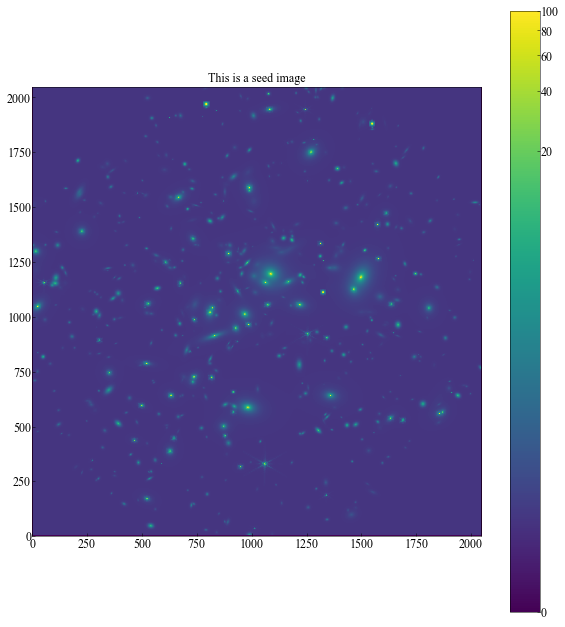

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
norm = simple_norm(data[:, :], stretch='log', min_cut=0, max_cut=100)
cax = ax.imshow(data[:, :], norm=norm)
cbar = fig.colorbar(cax)
plt.title('This is a seed image')
plt.show()

In [35]:
# Compare with the real F160W image, if you have
real_file = './cls_f160w_v1.0-epoch2_drz.fits'
with fits.open(real_file) as hdulist:
    data_real = hdulist[0].data
    hdulist.info()

Filename: ./cls_f160w_v1.0-epoch2_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1652   (5350, 6150)   float32   


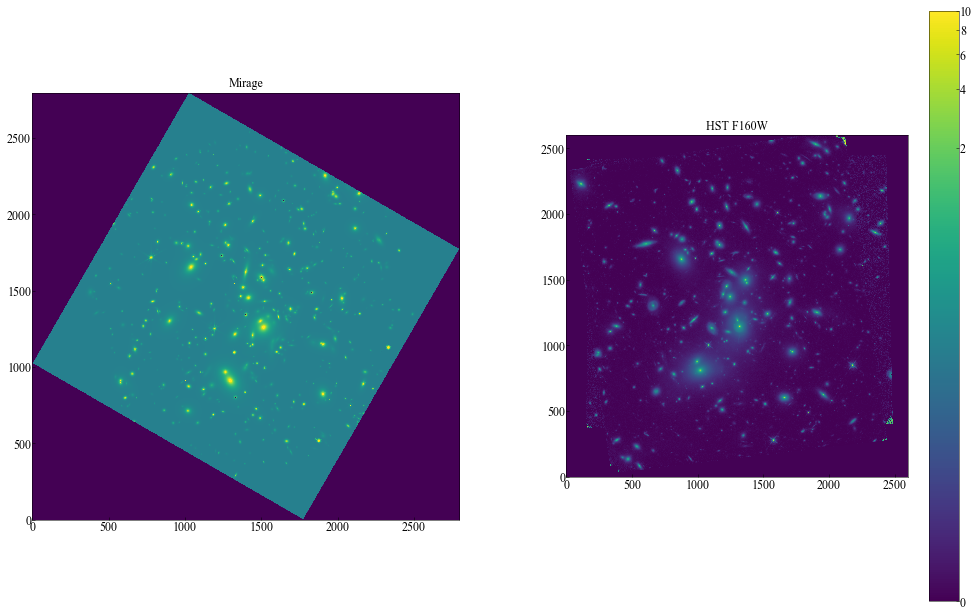

In [38]:
from scipy import ndimage

fig = plt.figure(figsize=(15.,10.))
fig.subplots_adjust(top=0.98, bottom=0.16, left=0.1, right=0.99, hspace=0.15, wspace=0.25)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

norm = simple_norm(data[:,:], stretch='log', min_cut=0, max_cut=10)
rotated_img = ndimage.rotate(data[:,:], pav3*60)

cax = ax1.imshow(rotated_img, norm=norm)

norm = simple_norm(data_real[1200:3800, 1200:3800], stretch='log', min_cut=0, max_cut=10)
cax = ax2.imshow(data_real[1200:3800, 1200:3800], norm=norm)
cbar = fig.colorbar(cax)
ax1.set_title('Mirage')
ax2.set_title('HST F160W')
plt.savefig('01_comparison.png')

#### Also check uncal image, i.e. simulated images with noise.

In [39]:
final_file = os.path.join(simulations_output_dir, '%s_uncal.fits'%checkid)
with fits.open(final_file) as hdulist:
    data = hdulist['SCI'].data
    hdulist.info()

Filename: ./output/jw00042001001_01101_00012_nis_uncal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     120   ()      
  1  SCI           1 ImageHDU        50   (2048, 2048, 16, 1)   uint16   
  2  ZEROFRAME     1 ImageHDU        12   (2048, 2048, 1)   int16 (rescales to uint16)   
  3  GROUP         1 BinTableHDU     36   16R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  4  INT_TIMES     1 BinTableHDU     24   1R x 7C   [J, D, D, D, D, D, D]   
  5  ASDF          1 BinTableHDU     11   1R x 1C   [4362B]   


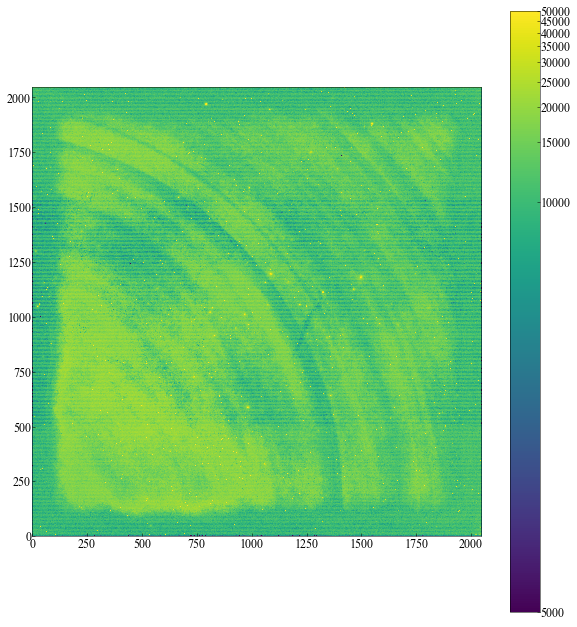

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))
norm = simple_norm(data[0, -1, :, :], stretch='log', min_cut=5000, max_cut=50000)
cax = ax.imshow(data[0, -1, :, :], norm=norm)
cbar = fig.colorbar(cax)
plt.show()

### Run WFSS simulation as well

#### We first prepare SED for each source. 

This can be done either by 1. using SED fitting result from HST photometry, 2. simply assume a uniform SED for all sources, or 3. let Mirage extraporate from input catalog.

Here, just for simplicity, I let Mirage interporate SED (3).

In [41]:
yaml_output_dir = './yaml/' #TEST_DATA_DIRECTORY
simulations_output_dir = './output/' #TEST_DATA_DIRECTORY
yaml_files = glob(os.path.join(yaml_output_dir,"jw*.yaml"))

yaml_WFSS_files = []
yaml_NIRISS_imaging_files = []
for f in yaml_files:
    my_dict = yaml.safe_load(open(f))
    if my_dict["Inst"]["mode"]=="wfss":
        yaml_WFSS_files.append(f)
    if my_dict["Inst"]["mode"]=="imaging" and my_dict['Inst']['instrument']=='NIRISS':
        yaml_NIRISS_imaging_files.append(f)
    
print("WFSS files:",len(yaml_WFSS_files))
print("Imaging files:",len(yaml_NIRISS_imaging_files))

WFSS files: 8
Imaging files: 4


#### Run for wfss --- it takes time...

In [87]:
from mirage import wfss_simulator

#os.system('rm source_sed_file_from_sources_point_01.hdf5')
for file in yaml_WFSS_files[:]:
    m = wfss_simulator.WFSSSim(file, override_dark=None, save_dispersed_seed=True,
                               extrapolate_SED=None, disp_seed_filename=None, source_stamps_file=None,
                               SED_file=None, SED_normalizing_catalog_column=None, SED_dict=None,
                               create_continuum_seds=True) #, disp_seed_filename=disp_seed_image

    m.create()

Running catalog_seed_image for ./yaml/jw00042001001_01101_00009_nis.yaml
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_mask_0013.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0029.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0011.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0010.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_gain_0002.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_flat_0163.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_ipc_0008.fits as the ipc reference file.
Found an existing 

Dispersing  21 of 37 ID: 1463
18 pixels loaded for dispersion...
Dispersion took: 0.09713888168334961 s.
Dispersing  22 of 37 ID: 311
8 pixels loaded for dispersion...
Dispersion took: 0.06441807746887207 s.
Dispersing  23 of 37 ID: 1210
8 pixels loaded for dispersion...
Dispersion took: 0.07660794258117676 s.
Dispersing  24 of 37 ID: 1346
9 pixels loaded for dispersion...
Dispersion took: 0.0847020149230957 s.
Dispersing  25 of 37 ID: 204
17 pixels loaded for dispersion...
Dispersion took: 0.09463191032409668 s.
Dispersing  26 of 37 ID: 77
21 pixels loaded for dispersion...
Dispersion took: 0.08450794219970703 s.
Dispersing  27 of 37 ID: 720
16 pixels loaded for dispersion...
Dispersion took: 0.09177017211914062 s.
Dispersing  28 of 37 ID: 721
7 pixels loaded for dispersion...
Dispersion took: 0.07649779319763184 s.
Dispersing  29 of 37 ID: 472
5 pixels loaded for dispersion...
Dispersion took: 0.07388901710510254 s.
Dispersing  30 of 37 ID: 857
25 pixels loaded for dispersion...
Disp

33 pixels loaded for dispersion...
Dispersion took: 0.10601377487182617 s.
Dispersing  56 of 454 ID: 10498
74 pixels loaded for dispersion...
Dispersion took: 0.15204095840454102 s.
Dispersing  57 of 454 ID: 10501
138 pixels loaded for dispersion...
Dispersion took: 0.2281341552734375 s.
Dispersing  58 of 454 ID: 10503
3 pixels loaded for dispersion...
Dispersion took: 0.06622791290283203 s.
Dispersing  59 of 454 ID: 10504
5 pixels loaded for dispersion...
Dispersion took: 0.07249212265014648 s.
Dispersing  60 of 454 ID: 10505
447 pixels loaded for dispersion...
Dispersion took: 0.8485829830169678 s.
Dispersing  61 of 454 ID: 10507
57 pixels loaded for dispersion...
Dispersion took: 0.15815496444702148 s.
Dispersing  62 of 454 ID: 10510
702 pixels loaded for dispersion...
Dispersion took: 1.283276081085205 s.
Dispersing  63 of 454 ID: 10522
10 pixels loaded for dispersion...
Dispersion took: 0.0750129222869873 s.
Dispersing  64 of 454 ID: 10523
4 pixels loaded for dispersion...
Dispers

Dispersion took: 0.06616592407226562 s.
Dispersing  208 of 454 ID: 11064
33 pixels loaded for dispersion...
Dispersion took: 0.12343192100524902 s.
Dispersing  209 of 454 ID: 11065
166 pixels loaded for dispersion...
Dispersion took: 0.37708115577697754 s.
Dispersing  210 of 454 ID: 11066
383 pixels loaded for dispersion...
Dispersion took: 0.759749174118042 s.
Dispersing  211 of 454 ID: 11067
13 pixels loaded for dispersion...
Dispersion took: 0.08691525459289551 s.
Dispersing  212 of 454 ID: 11068
714 pixels loaded for dispersion...
Dispersion took: 1.4010610580444336 s.
Dispersing  213 of 454 ID: 11069
115 pixels loaded for dispersion...
Dispersion took: 0.2872183322906494 s.
Dispersing  214 of 454 ID: 11070
334 pixels loaded for dispersion...
Dispersion took: 0.6232357025146484 s.
Dispersing  215 of 454 ID: 11071
148 pixels loaded for dispersion...
Dispersion took: 0.3161501884460449 s.
Dispersing  216 of 454 ID: 11072
343 pixels loaded for dispersion...
Dispersion took: 0.67764902

Dispersion took: 0.6044642925262451 s.
Dispersing  284 of 454 ID: 11305
211 pixels loaded for dispersion...
Dispersion took: 0.43225908279418945 s.
Dispersing  285 of 454 ID: 11309
199 pixels loaded for dispersion...
Dispersion took: 0.401292085647583 s.
Dispersing  286 of 454 ID: 11310
106 pixels loaded for dispersion...
Dispersion took: 0.2483530044555664 s.
Dispersing  287 of 454 ID: 11311
136 pixels loaded for dispersion...
Dispersion took: 0.2904479503631592 s.
Dispersing  288 of 454 ID: 11312
79 pixels loaded for dispersion...
Dispersion took: 0.19507598876953125 s.
Dispersing  289 of 454 ID: 11313
13 pixels loaded for dispersion...
Dispersion took: 0.08193421363830566 s.
Dispersing  290 of 454 ID: 11314
431 pixels loaded for dispersion...
Dispersion took: 0.7689740657806396 s.
Dispersing  291 of 454 ID: 11315
1273 pixels loaded for dispersion...
Dispersion took: 2.151266098022461 s.
Dispersing  292 of 454 ID: 11316
7471 pixels loaded for dispersion...
Dispersion took: 12.4764070

Dispersion took: 0.07182598114013672 s.
Dispersing  436 of 454 ID: 10109
13 pixels loaded for dispersion...
Dispersion took: 0.07981109619140625 s.
Dispersing  437 of 454 ID: 10120
1 pixels loaded for dispersion...
Dispersion took: 0.06837916374206543 s.
Dispersing  438 of 454 ID: 10121
161 pixels loaded for dispersion...
Dispersion took: 0.33719611167907715 s.
Dispersing  439 of 454 ID: 10122
483 pixels loaded for dispersion...
Dispersion took: 0.9128038883209229 s.
Dispersing  440 of 454 ID: 10123
22 pixels loaded for dispersion...
Dispersion took: 0.09805798530578613 s.
Dispersing  441 of 454 ID: 10124
62 pixels loaded for dispersion...
Dispersion took: 0.17835116386413574 s.
Dispersing  442 of 454 ID: 10135
18 pixels loaded for dispersion...
Dispersion took: 0.0901801586151123 s.
Dispersing  443 of 454 ID: 10140
25 pixels loaded for dispersion...
Dispersion took: 0.10749602317810059 s.
Dispersing  444 of 454 ID: 10143
33 pixels loaded for dispersion...
Dispersion took: 0.1187119483

99 pixels loaded for dispersion...
Dispersion took: 0.18619012832641602 s.
Dispersing  135 of 454 ID: 10792
13 pixels loaded for dispersion...
Dispersion took: 0.0722036361694336 s.
Dispersing  136 of 454 ID: 10794
94 pixels loaded for dispersion...
Dispersion took: 0.1763463020324707 s.
Dispersing  137 of 454 ID: 10795
261 pixels loaded for dispersion...
Dispersion took: 0.379899263381958 s.
Dispersing  138 of 454 ID: 10804
3 pixels loaded for dispersion...
Dispersion took: 0.06574296951293945 s.
Dispersing  139 of 454 ID: 10805
6 pixels loaded for dispersion...
Dispersion took: 0.06884765625 s.
Dispersing  140 of 454 ID: 10806
272 pixels loaded for dispersion...
Dispersion took: 0.3925940990447998 s.
Dispersing  141 of 454 ID: 10807
10 pixels loaded for dispersion...
Dispersion took: 0.07050085067749023 s.
Dispersing  142 of 454 ID: 10813
1 pixels loaded for dispersion...
Dispersion took: 0.06650996208190918 s.
Dispersing  143 of 454 ID: 10830
5 pixels loaded for dispersion...
Disper

Dispersing  286 of 454 ID: 11310
106 pixels loaded for dispersion...
Dispersion took: 0.1960618495941162 s.
Dispersing  287 of 454 ID: 11311
136 pixels loaded for dispersion...
Dispersion took: 0.240067720413208 s.
Dispersing  288 of 454 ID: 11312
79 pixels loaded for dispersion...
Dispersion took: 0.16672706604003906 s.
Dispersing  289 of 454 ID: 11313
13 pixels loaded for dispersion...
Dispersion took: 0.07726693153381348 s.
Dispersing  290 of 454 ID: 11314
431 pixels loaded for dispersion...
Dispersion took: 0.6029539108276367 s.
Dispersing  291 of 454 ID: 11315
1273 pixels loaded for dispersion...
Dispersion took: 1.617523193359375 s.
Dispersing  292 of 454 ID: 11316
7471 pixels loaded for dispersion...
Dispersion took: 9.053606271743774 s.
Dispersing  293 of 454 ID: 11317
137 pixels loaded for dispersion...
Dispersion took: 0.22813105583190918 s.
Dispersing  294 of 454 ID: 11320
45 pixels loaded for dispersion...
Dispersion took: 0.11907410621643066 s.
Dispersing  295 of 454 ID: 1

Dispersing  438 of 454 ID: 10121
161 pixels loaded for dispersion...
Dispersion took: 0.2747981548309326 s.
Dispersing  439 of 454 ID: 10122
483 pixels loaded for dispersion...
Dispersion took: 0.6856589317321777 s.
Dispersing  440 of 454 ID: 10123
22 pixels loaded for dispersion...
Dispersion took: 0.09030890464782715 s.
Dispersing  441 of 454 ID: 10124
62 pixels loaded for dispersion...
Dispersion took: 0.15365076065063477 s.
Dispersing  442 of 454 ID: 10135
18 pixels loaded for dispersion...
Dispersion took: 0.0827479362487793 s.
Dispersing  443 of 454 ID: 10140
25 pixels loaded for dispersion...
Dispersion took: 0.0966649055480957 s.
Dispersing  444 of 454 ID: 10143
33 pixels loaded for dispersion...
Dispersion took: 0.11084794998168945 s.
Dispersing  445 of 454 ID: 10169
2 pixels loaded for dispersion...
Dispersion took: 0.06852412223815918 s.
Dispersing  446 of 454 ID: 10178
173 pixels loaded for dispersion...
Dispersion took: 0.2903289794921875 s.
Dispersing  447 of 454 ID: 1018

Dispersion took: 0.27778100967407227 s.
Dispersing  137 of 454 ID: 10795
261 pixels loaded for dispersion...
Dispersion took: 0.6327250003814697 s.
Dispersing  138 of 454 ID: 10804
3 pixels loaded for dispersion...
Dispersion took: 0.06580495834350586 s.
Dispersing  139 of 454 ID: 10805
6 pixels loaded for dispersion...
Dispersion took: 0.07633590698242188 s.
Dispersing  140 of 454 ID: 10806
272 pixels loaded for dispersion...
Dispersion took: 0.617196798324585 s.
Dispersing  141 of 454 ID: 10807
10 pixels loaded for dispersion...
Dispersion took: 0.08279585838317871 s.
Dispersing  142 of 454 ID: 10813
1 pixels loaded for dispersion...
Dispersion took: 0.06324481964111328 s.
Dispersing  143 of 454 ID: 10830
5 pixels loaded for dispersion...
Dispersion took: 0.07493305206298828 s.
Dispersing  144 of 454 ID: 10831
6 pixels loaded for dispersion...
Dispersion took: 0.07976889610290527 s.
Dispersing  145 of 454 ID: 10834
9 pixels loaded for dispersion...
Dispersion took: 0.0734088420867919

Dispersion took: 0.2445240020751953 s.
Dispersing  289 of 454 ID: 11313
13 pixels loaded for dispersion...
Dispersion took: 0.08885383605957031 s.
Dispersing  290 of 454 ID: 11314
431 pixels loaded for dispersion...
Dispersion took: 1.0161750316619873 s.
Dispersing  291 of 454 ID: 11315
1273 pixels loaded for dispersion...
Dispersion took: 2.8932249546051025 s.
Dispersing  292 of 454 ID: 11316
7471 pixels loaded for dispersion...
Dispersion took: 16.26741075515747 s.
Dispersing  293 of 454 ID: 11317
137 pixels loaded for dispersion...
Dispersion took: 0.3331270217895508 s.
Dispersing  294 of 454 ID: 11320
45 pixels loaded for dispersion...
Dispersion took: 0.16673588752746582 s.
Dispersing  295 of 454 ID: 11322
5 pixels loaded for dispersion...
Dispersion took: 0.07437610626220703 s.
Dispersing  296 of 454 ID: 11329
8 pixels loaded for dispersion...
Dispersion took: 0.07948708534240723 s.
Dispersing  297 of 454 ID: 11330
4 pixels loaded for dispersion...
Dispersion took: 0.073562860488

Dispersion took: 0.09403419494628906 s.
Dispersing  441 of 454 ID: 10124
62 pixels loaded for dispersion...
Dispersion took: 0.14804506301879883 s.
Dispersing  442 of 454 ID: 10135
18 pixels loaded for dispersion...
Dispersion took: 0.10439229011535645 s.
Dispersing  443 of 454 ID: 10140
25 pixels loaded for dispersion...
Dispersion took: 0.12147092819213867 s.
Dispersing  444 of 454 ID: 10143
33 pixels loaded for dispersion...
Dispersion took: 0.11583209037780762 s.
Dispersing  445 of 454 ID: 10169
2 pixels loaded for dispersion...
Dispersion took: 0.06474876403808594 s.
Dispersing  446 of 454 ID: 10178
173 pixels loaded for dispersion...
Dispersion took: 0.46788597106933594 s.
Dispersing  447 of 454 ID: 10184
8 pixels loaded for dispersion...
Dispersion took: 0.07902789115905762 s.
Dispersing  448 of 454 ID: 10203
273 pixels loaded for dispersion...
Dispersion took: 0.6900198459625244 s.
Dispersing  449 of 454 ID: 10214
45 pixels loaded for dispersion...
Dispersion took: 0.1475141048

6 pixels loaded for dispersion...
Dispersion took: 0.07955002784729004 s.
Dispersing  140 of 454 ID: 10806
272 pixels loaded for dispersion...
Dispersion took: 0.38617897033691406 s.
Dispersing  141 of 454 ID: 10807
10 pixels loaded for dispersion...
Dispersion took: 0.08860993385314941 s.
Dispersing  142 of 454 ID: 10813
1 pixels loaded for dispersion...
Dispersion took: 0.06209993362426758 s.
Dispersing  143 of 454 ID: 10830
5 pixels loaded for dispersion...
Dispersion took: 0.07410717010498047 s.
Dispersing  144 of 454 ID: 10831
6 pixels loaded for dispersion...
Dispersion took: 0.07714009284973145 s.
Dispersing  145 of 454 ID: 10834
9 pixels loaded for dispersion...
Dispersion took: 0.07190203666687012 s.
Dispersing  146 of 454 ID: 10842
73 pixels loaded for dispersion...
Dispersion took: 0.27568674087524414 s.
Dispersing  147 of 454 ID: 10843
34 pixels loaded for dispersion...
Dispersion took: 0.16788721084594727 s.
Dispersing  148 of 454 ID: 10845
89 pixels loaded for dispersion.

1273 pixels loaded for dispersion...
Dispersion took: 3.468050956726074 s.
Dispersing  292 of 454 ID: 11316
7471 pixels loaded for dispersion...
Dispersion took: 19.917157888412476 s.
Dispersing  293 of 454 ID: 11317
137 pixels loaded for dispersion...
Dispersion took: 0.26328277587890625 s.
Dispersing  294 of 454 ID: 11320
45 pixels loaded for dispersion...
Dispersion took: 0.19262099266052246 s.
Dispersing  295 of 454 ID: 11322
5 pixels loaded for dispersion...
Dispersion took: 0.07489180564880371 s.
Dispersing  296 of 454 ID: 11329
8 pixels loaded for dispersion...
Dispersion took: 0.08008599281311035 s.
Dispersing  297 of 454 ID: 11330
4 pixels loaded for dispersion...
Dispersion took: 0.06837773323059082 s.
Dispersing  298 of 454 ID: 11334
579 pixels loaded for dispersion...
Dispersion took: 0.8163728713989258 s.
Dispersing  299 of 454 ID: 11351
2 pixels loaded for dispersion...
Dispersion took: 0.05995607376098633 s.
Dispersing  300 of 454 ID: 11352
447 pixels loaded for dispersi

25 pixels loaded for dispersion...
Dispersion took: 0.09740591049194336 s.
Dispersing  444 of 454 ID: 10143
33 pixels loaded for dispersion...
Dispersion took: 0.11010885238647461 s.
Dispersing  445 of 454 ID: 10169
2 pixels loaded for dispersion...
Dispersion took: 0.06339693069458008 s.
Dispersing  446 of 454 ID: 10178
173 pixels loaded for dispersion...
Dispersion took: 0.48283863067626953 s.
Dispersing  447 of 454 ID: 10184
8 pixels loaded for dispersion...
Dispersion took: 0.06653285026550293 s.
Dispersing  448 of 454 ID: 10203
273 pixels loaded for dispersion...
Dispersion took: 0.5308830738067627 s.
Dispersing  449 of 454 ID: 10214
45 pixels loaded for dispersion...
Dispersion took: 0.1259160041809082 s.
Dispersing  450 of 454 ID: 10218
7 pixels loaded for dispersion...
Dispersion took: 0.07351016998291016 s.
Dispersing  451 of 454 ID: 10228
7 pixels loaded for dispersion...
Dispersion took: 0.06670165061950684 s.
Dispersing  452 of 454 ID: 10229
1 pixels loaded for dispersion..

Dispersion took: 0.07887530326843262 s.
Dispersing  142 of 454 ID: 10813
1 pixels loaded for dispersion...
Dispersion took: 0.07108306884765625 s.
Dispersing  143 of 454 ID: 10830
5 pixels loaded for dispersion...
Dispersion took: 0.0761880874633789 s.
Dispersing  144 of 454 ID: 10831
6 pixels loaded for dispersion...
Dispersion took: 0.07592201232910156 s.
Dispersing  145 of 454 ID: 10834
9 pixels loaded for dispersion...
Dispersion took: 0.08198881149291992 s.
Dispersing  146 of 454 ID: 10842
73 pixels loaded for dispersion...
Dispersion took: 0.19915485382080078 s.
Dispersing  147 of 454 ID: 10843
34 pixels loaded for dispersion...
Dispersion took: 0.1276378631591797 s.
Dispersing  148 of 454 ID: 10845
89 pixels loaded for dispersion...
Dispersion took: 0.22751116752624512 s.
Dispersing  149 of 454 ID: 10846
378 pixels loaded for dispersion...
Dispersion took: 0.7412159442901611 s.
Dispersing  150 of 454 ID: 10852
335 pixels loaded for dispersion...
Dispersion took: 0.68467378616333

Dispersion took: 0.18923211097717285 s.
Dispersing  218 of 454 ID: 11074
311 pixels loaded for dispersion...
Dispersion took: 0.5991592407226562 s.
Dispersing  219 of 454 ID: 11075
953 pixels loaded for dispersion...
Dispersion took: 1.6942481994628906 s.
Dispersing  220 of 454 ID: 11076
7373 pixels loaded for dispersion...
Dispersion took: 12.540138959884644 s.
Dispersing  221 of 454 ID: 11087
30 pixels loaded for dispersion...
Dispersion took: 0.11314916610717773 s.
Dispersing  222 of 454 ID: 11090
42 pixels loaded for dispersion...
Dispersion took: 0.13721394538879395 s.
Dispersing  223 of 454 ID: 11092
155 pixels loaded for dispersion...
Dispersion took: 0.2959589958190918 s.
Dispersing  224 of 454 ID: 11093
42 pixels loaded for dispersion...
Dispersion took: 0.12201809883117676 s.
Dispersing  225 of 454 ID: 11094
146 pixels loaded for dispersion...
Dispersion took: 0.3117640018463135 s.
Dispersing  226 of 454 ID: 11096
62 pixels loaded for dispersion...
Dispersion took: 0.16569590

40 pixels loaded for dispersion...
Dispersion took: 0.1266920566558838 s.
Dispersing  370 of 454 ID: 11751
37 pixels loaded for dispersion...
Dispersion took: 0.12627291679382324 s.
Dispersing  371 of 454 ID: 11765
1 pixels loaded for dispersion...
Dispersion took: 0.06827688217163086 s.
Dispersing  372 of 454 ID: 11788
31 pixels loaded for dispersion...
Dispersion took: 0.12340807914733887 s.
Dispersing  373 of 454 ID: 11790
56 pixels loaded for dispersion...
Dispersion took: 0.14099669456481934 s.
Dispersing  374 of 454 ID: 11792
89 pixels loaded for dispersion...
Dispersion took: 0.1655900478363037 s.
Dispersing  375 of 454 ID: 11794
20 pixels loaded for dispersion...
Dispersion took: 0.09053277969360352 s.
Dispersing  376 of 454 ID: 11795
24 pixels loaded for dispersion...
Dispersion took: 0.09963226318359375 s.
Dispersing  377 of 454 ID: 11796
58 pixels loaded for dispersion...
Dispersion took: 0.14215087890625 s.
Dispersing  378 of 454 ID: 11798
356 pixels loaded for dispersion..

    Averaging frame 10 into group 2
    Averaging frame 11 into group 2
    Averaging frame 12 into group 3
    Averaging frame 13 into group 3
    Averaging frame 14 into group 3
    Averaging frame 15 into group 3
    Averaging frame 16 into group 4
    Averaging frame 17 into group 4
    Averaging frame 18 into group 4
    Averaging frame 19 into group 4
    Averaging frame 20 into group 5
    Averaging frame 21 into group 5
    Averaging frame 22 into group 5
    Averaging frame 23 into group 5
    Averaging frame 24 into group 6
    Averaging frame 25 into group 6
    Averaging frame 26 into group 6
    Averaging frame 27 into group 6
    Averaging frame 28 into group 7
    Averaging frame 29 into group 7
    Averaging frame 30 into group 7
    Averaging frame 31 into group 7
    Averaging frame 32 into group 8
    Averaging frame 33 into group 8
    Averaging frame 34 into group 8
    Averaging frame 35 into group 8
    Averaging frame 36 into group 9
    Averaging frame 37 into 

WCS info for /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00009_nis_linear.fits complete.


Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00009_nis_linear.fits
Unlinearizing exposure.
Adding superbias and reference pixel signals.


Populating xref_sci in output file:
1024.5


WCS info for /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00009_nis_uncal.fits complete.


Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00009_nis_uncal.fits
Observation generation complete.
Running catalog_seed_image for ./yaml/jw00042001001_01101_00003_nis.yaml
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_mask_0013.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0029.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0011.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0010.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_gain_0002.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_flat_0180.fits as th

23 pixels loaded for dispersion...
Dispersion took: 0.11014699935913086 s.
Dispersing  20 of 37 ID: 694
15 pixels loaded for dispersion...
Dispersion took: 0.08729124069213867 s.
Dispersing  21 of 37 ID: 1463
17 pixels loaded for dispersion...
Dispersion took: 0.09664797782897949 s.
Dispersing  22 of 37 ID: 311
7 pixels loaded for dispersion...
Dispersion took: 0.07667398452758789 s.
Dispersing  23 of 37 ID: 1210
9 pixels loaded for dispersion...
Dispersion took: 0.07900810241699219 s.
Dispersing  24 of 37 ID: 1346
9 pixels loaded for dispersion...
Dispersion took: 0.07907795906066895 s.
Dispersing  25 of 37 ID: 204
16 pixels loaded for dispersion...
Dispersion took: 0.07951807975769043 s.
Dispersing  26 of 37 ID: 77
22 pixels loaded for dispersion...
Dispersion took: 0.09178018569946289 s.
Dispersing  27 of 37 ID: 720
15 pixels loaded for dispersion...
Dispersion took: 0.0933682918548584 s.
Dispersing  28 of 37 ID: 721
6 pixels loaded for dispersion...
Dispersion took: 0.0755691528320

Dispersion took: 0.08574295043945312 s.
Dispersing  54 of 454 ID: 10489
618 pixels loaded for dispersion...
Dispersion took: 1.119203805923462 s.
Dispersing  55 of 454 ID: 10492
85 pixels loaded for dispersion...
Dispersion took: 0.2070469856262207 s.
Dispersing  56 of 454 ID: 10493
30 pixels loaded for dispersion...
Dispersion took: 0.11961793899536133 s.
Dispersing  57 of 454 ID: 10497
33 pixels loaded for dispersion...
Dispersion took: 0.11774516105651855 s.
Dispersing  58 of 454 ID: 10498
71 pixels loaded for dispersion...
Dispersion took: 0.18392086029052734 s.
Dispersing  59 of 454 ID: 10501
141 pixels loaded for dispersion...
Dispersion took: 0.30931806564331055 s.
Dispersing  60 of 454 ID: 10503
4 pixels loaded for dispersion...
Dispersion took: 0.06985688209533691 s.
Dispersing  61 of 454 ID: 10504
6 pixels loaded for dispersion...
Dispersion took: 0.07209396362304688 s.
Dispersing  62 of 454 ID: 10505
450 pixels loaded for dispersion...
Dispersion took: 0.8421721458435059 s.


Dispersion took: 0.2016451358795166 s.
Dispersing  206 of 454 ID: 11060
23 pixels loaded for dispersion...
Dispersion took: 0.0984492301940918 s.
Dispersing  207 of 454 ID: 11061
3 pixels loaded for dispersion...
Dispersion took: 0.06916618347167969 s.
Dispersing  208 of 454 ID: 11062
557 pixels loaded for dispersion...
Dispersion took: 0.9962387084960938 s.
Dispersing  209 of 454 ID: 11063
2 pixels loaded for dispersion...
Dispersion took: 0.061920881271362305 s.
Dispersing  210 of 454 ID: 11064
35 pixels loaded for dispersion...
Dispersion took: 0.12422990798950195 s.
Dispersing  211 of 454 ID: 11065
169 pixels loaded for dispersion...
Dispersion took: 0.3474571704864502 s.
Dispersing  212 of 454 ID: 11066
378 pixels loaded for dispersion...
Dispersion took: 0.7038407325744629 s.
Dispersing  213 of 454 ID: 11067
13 pixels loaded for dispersion...
Dispersion took: 0.07523870468139648 s.
Dispersing  214 of 454 ID: 11068
701 pixels loaded for dispersion...
Dispersion took: 1.24278092384

Dispersion took: 0.09273195266723633 s.
Dispersing  358 of 454 ID: 11647
38 pixels loaded for dispersion...
Dispersion took: 0.1394031047821045 s.
Dispersing  359 of 454 ID: 11650
217 pixels loaded for dispersion...
Dispersion took: 0.45800089836120605 s.
Dispersing  360 of 454 ID: 11655
72 pixels loaded for dispersion...
Dispersion took: 0.20500516891479492 s.
Dispersing  361 of 454 ID: 11657
265 pixels loaded for dispersion...
Dispersion took: 0.5291147232055664 s.
Dispersing  362 of 454 ID: 11662
3 pixels loaded for dispersion...
Dispersion took: 0.07286238670349121 s.
Dispersing  363 of 454 ID: 11664
407 pixels loaded for dispersion...
Dispersion took: 0.7697851657867432 s.
Dispersing  364 of 454 ID: 11669
54 pixels loaded for dispersion...
Dispersion took: 0.1538381576538086 s.
Dispersing  365 of 454 ID: 11672
132 pixels loaded for dispersion...
Dispersion took: 0.28552794456481934 s.
Dispersing  366 of 454 ID: 11682
68 pixels loaded for dispersion...
Dispersion took: 0.1776177883

Dispersing  56 of 454 ID: 10493
30 pixels loaded for dispersion...
Dispersion took: 0.10512900352478027 s.
Dispersing  57 of 454 ID: 10497
33 pixels loaded for dispersion...
Dispersion took: 0.10762691497802734 s.
Dispersing  58 of 454 ID: 10498
71 pixels loaded for dispersion...
Dispersion took: 0.16264700889587402 s.
Dispersing  59 of 454 ID: 10501
141 pixels loaded for dispersion...
Dispersion took: 0.24078106880187988 s.
Dispersing  60 of 454 ID: 10503
4 pixels loaded for dispersion...
Dispersion took: 0.07109808921813965 s.
Dispersing  61 of 454 ID: 10504
6 pixels loaded for dispersion...
Dispersion took: 0.06804394721984863 s.
Dispersing  62 of 454 ID: 10505
450 pixels loaded for dispersion...
Dispersion took: 0.6169400215148926 s.
Dispersing  63 of 454 ID: 10507
57 pixels loaded for dispersion...
Dispersion took: 0.14472484588623047 s.
Dispersing  64 of 454 ID: 10510
698 pixels loaded for dispersion...
Dispersion took: 0.9273321628570557 s.
Dispersing  65 of 454 ID: 10522
11 pix

557 pixels loaded for dispersion...
Dispersion took: 0.7572159767150879 s.
Dispersing  209 of 454 ID: 11063
2 pixels loaded for dispersion...
Dispersion took: 0.06869673728942871 s.
Dispersing  210 of 454 ID: 11064
35 pixels loaded for dispersion...
Dispersion took: 0.11335897445678711 s.
Dispersing  211 of 454 ID: 11065
169 pixels loaded for dispersion...
Dispersion took: 0.2874739170074463 s.
Dispersing  212 of 454 ID: 11066
378 pixels loaded for dispersion...
Dispersion took: 0.505903959274292 s.
Dispersing  213 of 454 ID: 11067
13 pixels loaded for dispersion...
Dispersion took: 0.07629013061523438 s.
Dispersing  214 of 454 ID: 11068
701 pixels loaded for dispersion...
Dispersion took: 0.8882958889007568 s.
Dispersing  215 of 454 ID: 11069
110 pixels loaded for dispersion...
Dispersion took: 0.2021939754486084 s.
Dispersing  216 of 454 ID: 11070
334 pixels loaded for dispersion...
Dispersion took: 0.48453617095947266 s.
Dispersing  217 of 454 ID: 11071
151 pixels loaded for dispers

13 pixels loaded for dispersion...
Dispersion took: 0.08172082901000977 s.
Dispersing  285 of 454 ID: 11302
301 pixels loaded for dispersion...
Dispersion took: 0.4482440948486328 s.
Dispersing  286 of 454 ID: 11305
218 pixels loaded for dispersion...
Dispersion took: 0.35140180587768555 s.
Dispersing  287 of 454 ID: 11309
198 pixels loaded for dispersion...
Dispersion took: 0.3428831100463867 s.
Dispersing  288 of 454 ID: 11310
105 pixels loaded for dispersion...
Dispersion took: 0.19594120979309082 s.
Dispersing  289 of 454 ID: 11311
137 pixels loaded for dispersion...
Dispersion took: 0.24879074096679688 s.
Dispersing  290 of 454 ID: 11312
82 pixels loaded for dispersion...
Dispersion took: 0.1699690818786621 s.
Dispersing  291 of 454 ID: 11313
10 pixels loaded for dispersion...
Dispersion took: 0.07183504104614258 s.
Dispersing  292 of 454 ID: 11314
440 pixels loaded for dispersion...
Dispersion took: 0.6094660758972168 s.
Dispersing  293 of 454 ID: 11315
1269 pixels loaded for dis

11 pixels loaded for dispersion...
Dispersion took: 0.07543396949768066 s.
Dispersing  437 of 454 ID: 10120
1 pixels loaded for dispersion...
Dispersion took: 0.06480789184570312 s.
Dispersing  438 of 454 ID: 10121
158 pixels loaded for dispersion...
Dispersion took: 0.25217199325561523 s.
Dispersing  439 of 454 ID: 10122
485 pixels loaded for dispersion...
Dispersion took: 0.6728448867797852 s.
Dispersing  440 of 454 ID: 10123
22 pixels loaded for dispersion...
Dispersion took: 0.09563422203063965 s.
Dispersing  441 of 454 ID: 10124
64 pixels loaded for dispersion...
Dispersion took: 0.15085101127624512 s.
Dispersing  442 of 454 ID: 10135
17 pixels loaded for dispersion...
Dispersion took: 0.0914769172668457 s.
Dispersing  443 of 454 ID: 10140
27 pixels loaded for dispersion...
Dispersion took: 0.10395479202270508 s.
Dispersing  444 of 454 ID: 10143
32 pixels loaded for dispersion...
Dispersion took: 0.10747385025024414 s.
Dispersing  445 of 454 ID: 10169
3 pixels loaded for dispersio

Dispersing  135 of 454 ID: 10771
10 pixels loaded for dispersion...
Dispersion took: 0.07355284690856934 s.
Dispersing  136 of 454 ID: 10775
448 pixels loaded for dispersion...
Dispersion took: 0.9919528961181641 s.
Dispersing  137 of 454 ID: 10788
101 pixels loaded for dispersion...
Dispersion took: 0.2863140106201172 s.
Dispersing  138 of 454 ID: 10792
13 pixels loaded for dispersion...
Dispersion took: 0.07738709449768066 s.
Dispersing  139 of 454 ID: 10794
89 pixels loaded for dispersion...
Dispersion took: 0.17434406280517578 s.
Dispersing  140 of 454 ID: 10795
263 pixels loaded for dispersion...
Dispersion took: 0.3561668395996094 s.
Dispersing  141 of 454 ID: 10804
3 pixels loaded for dispersion...
Dispersion took: 0.07304120063781738 s.
Dispersing  142 of 454 ID: 10805
8 pixels loaded for dispersion...
Dispersion took: 0.07344412803649902 s.
Dispersing  143 of 454 ID: 10806
272 pixels loaded for dispersion...
Dispersion took: 0.6640419960021973 s.
Dispersing  144 of 454 ID: 108

Dispersing  287 of 454 ID: 11309
198 pixels loaded for dispersion...
Dispersion took: 0.5024929046630859 s.
Dispersing  288 of 454 ID: 11310
105 pixels loaded for dispersion...
Dispersion took: 0.2940850257873535 s.
Dispersing  289 of 454 ID: 11311
137 pixels loaded for dispersion...
Dispersion took: 0.37482690811157227 s.
Dispersing  290 of 454 ID: 11312
82 pixels loaded for dispersion...
Dispersion took: 0.24855589866638184 s.
Dispersing  291 of 454 ID: 11313
10 pixels loaded for dispersion...
Dispersion took: 0.08157110214233398 s.
Dispersing  292 of 454 ID: 11314
440 pixels loaded for dispersion...
Dispersion took: 1.0507471561431885 s.
Dispersing  293 of 454 ID: 11315
1269 pixels loaded for dispersion...
Dispersion took: 2.7925591468811035 s.
Dispersing  294 of 454 ID: 11316
7483 pixels loaded for dispersion...
Dispersion took: 16.169975996017456 s.
Dispersing  295 of 454 ID: 11317
137 pixels loaded for dispersion...
Dispersion took: 0.3794219493865967 s.
Dispersing  296 of 454 ID

Dispersing  439 of 454 ID: 10122
485 pixels loaded for dispersion...
Dispersion took: 1.1555988788604736 s.
Dispersing  440 of 454 ID: 10123
22 pixels loaded for dispersion...
Dispersion took: 0.10636687278747559 s.
Dispersing  441 of 454 ID: 10124
64 pixels loaded for dispersion...
Dispersion took: 0.19799184799194336 s.
Dispersing  442 of 454 ID: 10135
17 pixels loaded for dispersion...
Dispersion took: 0.08489394187927246 s.
Dispersing  443 of 454 ID: 10140
27 pixels loaded for dispersion...
Dispersion took: 0.09879589080810547 s.
Dispersing  444 of 454 ID: 10143
32 pixels loaded for dispersion...
Dispersion took: 0.10542106628417969 s.
Dispersing  445 of 454 ID: 10169
3 pixels loaded for dispersion...
Dispersion took: 0.06833004951477051 s.
Dispersing  446 of 454 ID: 10178
217 pixels loaded for dispersion...
Dispersion took: 0.31518101692199707 s.
Dispersing  447 of 454 ID: 10184
7 pixels loaded for dispersion...
Dispersion took: 0.06708002090454102 s.
Dispersing  448 of 454 ID: 10

Dispersion took: 0.18793416023254395 s.
Dispersing  138 of 454 ID: 10792
13 pixels loaded for dispersion...
Dispersion took: 0.07730293273925781 s.
Dispersing  139 of 454 ID: 10794
89 pixels loaded for dispersion...
Dispersion took: 0.1718590259552002 s.
Dispersing  140 of 454 ID: 10795
263 pixels loaded for dispersion...
Dispersion took: 0.37195801734924316 s.
Dispersing  141 of 454 ID: 10804
3 pixels loaded for dispersion...
Dispersion took: 0.0730130672454834 s.
Dispersing  142 of 454 ID: 10805
8 pixels loaded for dispersion...
Dispersion took: 0.06535911560058594 s.
Dispersing  143 of 454 ID: 10806
272 pixels loaded for dispersion...
Dispersion took: 0.6364328861236572 s.
Dispersing  144 of 454 ID: 10807
9 pixels loaded for dispersion...
Dispersion took: 0.07030415534973145 s.
Dispersing  145 of 454 ID: 10813
1 pixels loaded for dispersion...
Dispersion took: 0.06585502624511719 s.
Dispersing  146 of 454 ID: 10830
5 pixels loaded for dispersion...
Dispersion took: 0.064453840255737

137 pixels loaded for dispersion...
Dispersion took: 0.44203734397888184 s.
Dispersing  290 of 454 ID: 11312
82 pixels loaded for dispersion...
Dispersion took: 0.2965278625488281 s.
Dispersing  291 of 454 ID: 11313
10 pixels loaded for dispersion...
Dispersion took: 0.09085798263549805 s.
Dispersing  292 of 454 ID: 11314
440 pixels loaded for dispersion...
Dispersion took: 1.2565791606903076 s.
Dispersing  293 of 454 ID: 11315
1269 pixels loaded for dispersion...
Dispersion took: 3.441948890686035 s.
Dispersing  294 of 454 ID: 11316
7483 pixels loaded for dispersion...
Dispersion took: 19.655102014541626 s.
Dispersing  295 of 454 ID: 11317
137 pixels loaded for dispersion...
Dispersion took: 0.4658639430999756 s.
Dispersing  296 of 454 ID: 11320
47 pixels loaded for dispersion...
Dispersion took: 0.19802308082580566 s.
Dispersing  297 of 454 ID: 11322
6 pixels loaded for dispersion...
Dispersion took: 0.08509206771850586 s.
Dispersing  298 of 454 ID: 11329
7 pixels loaded for dispersi

64 pixels loaded for dispersion...
Dispersion took: 0.13689970970153809 s.
Dispersing  442 of 454 ID: 10135
17 pixels loaded for dispersion...
Dispersion took: 0.07798600196838379 s.
Dispersing  443 of 454 ID: 10140
27 pixels loaded for dispersion...
Dispersion took: 0.09192276000976562 s.
Dispersing  444 of 454 ID: 10143
32 pixels loaded for dispersion...
Dispersion took: 0.09597277641296387 s.
Dispersing  445 of 454 ID: 10169
3 pixels loaded for dispersion...
Dispersion took: 0.06224822998046875 s.
Dispersing  446 of 454 ID: 10178
217 pixels loaded for dispersion...
Dispersion took: 0.2902059555053711 s.
Dispersing  447 of 454 ID: 10184
7 pixels loaded for dispersion...
Dispersion took: 0.06374812126159668 s.
Dispersing  448 of 454 ID: 10203
272 pixels loaded for dispersion...
Dispersion took: 0.344555139541626 s.
Dispersing  449 of 454 ID: 10214
45 pixels loaded for dispersion...
Dispersion took: 0.1165010929107666 s.
Dispersing  450 of 454 ID: 10218
9 pixels loaded for dispersion..

Dispersion took: 0.20587801933288574 s.
Dispersing  140 of 454 ID: 10795
263 pixels loaded for dispersion...
Dispersion took: 0.47831082344055176 s.
Dispersing  141 of 454 ID: 10804
3 pixels loaded for dispersion...
Dispersion took: 0.06537890434265137 s.
Dispersing  142 of 454 ID: 10805
8 pixels loaded for dispersion...
Dispersion took: 0.07134366035461426 s.
Dispersing  143 of 454 ID: 10806
272 pixels loaded for dispersion...
Dispersion took: 0.49117517471313477 s.
Dispersing  144 of 454 ID: 10807
9 pixels loaded for dispersion...
Dispersion took: 0.07409930229187012 s.
Dispersing  145 of 454 ID: 10813
1 pixels loaded for dispersion...
Dispersion took: 0.061944007873535156 s.
Dispersing  146 of 454 ID: 10830
5 pixels loaded for dispersion...
Dispersion took: 0.06539106369018555 s.
Dispersing  147 of 454 ID: 10831
7 pixels loaded for dispersion...
Dispersion took: 0.06911110877990723 s.
Dispersing  148 of 454 ID: 10834
9 pixels loaded for dispersion...
Dispersion took: 0.0699820518493

Dispersion took: 0.07363200187683105 s.
Dispersing  292 of 454 ID: 11314
440 pixels loaded for dispersion...
Dispersion took: 0.5360429286956787 s.
Dispersing  293 of 454 ID: 11315
1269 pixels loaded for dispersion...
Dispersion took: 2.064426898956299 s.
Dispersing  294 of 454 ID: 11316
7483 pixels loaded for dispersion...
Dispersion took: 11.652437925338745 s.
Dispersing  295 of 454 ID: 11317
137 pixels loaded for dispersion...
Dispersion took: 0.2526228427886963 s.
Dispersing  296 of 454 ID: 11320
47 pixels loaded for dispersion...
Dispersion took: 0.13634991645812988 s.
Dispersing  297 of 454 ID: 11322
6 pixels loaded for dispersion...
Dispersion took: 0.0691382884979248 s.
Dispersing  298 of 454 ID: 11329
7 pixels loaded for dispersion...
Dispersion took: 0.06949710845947266 s.
Dispersing  299 of 454 ID: 11330
6 pixels loaded for dispersion...
Dispersion took: 0.06636500358581543 s.
Dispersing  300 of 454 ID: 11334
581 pixels loaded for dispersion...
Dispersion took: 0.67094230651

Dispersion took: 0.10269427299499512 s.
Dispersing  444 of 454 ID: 10143
32 pixels loaded for dispersion...
Dispersion took: 0.11095809936523438 s.
Dispersing  445 of 454 ID: 10169
3 pixels loaded for dispersion...
Dispersion took: 0.06472206115722656 s.
Dispersing  446 of 454 ID: 10178
217 pixels loaded for dispersion...
Dispersion took: 0.4081401824951172 s.
Dispersing  447 of 454 ID: 10184
7 pixels loaded for dispersion...
Dispersion took: 0.072357177734375 s.
Dispersing  448 of 454 ID: 10203
272 pixels loaded for dispersion...
Dispersion took: 0.4956851005554199 s.
Dispersing  449 of 454 ID: 10214
45 pixels loaded for dispersion...
Dispersion took: 0.14211010932922363 s.
Dispersing  450 of 454 ID: 10218
9 pixels loaded for dispersion...
Dispersion took: 0.07282781600952148 s.
Dispersing  451 of 454 ID: 10228
7 pixels loaded for dispersion...
Dispersion took: 0.0705571174621582 s.
Dispersing  452 of 454 ID: 10229
1 pixels loaded for dispersion...
Dispersion took: 0.06553292274475098

WCS info for /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00003_nis_linear.fits complete.


Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00003_nis_linear.fits
Unlinearizing exposure.
Adding superbias and reference pixel signals.


Populating xref_sci in output file:
1024.5


WCS info for /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00003_nis_uncal.fits complete.


Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00003_nis_uncal.fits
Observation generation complete.
Running catalog_seed_image for ./yaml/jw00042001001_01101_00011_nis.yaml
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_mask_0013.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0029.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0011.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0010.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_gain_0002.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_flat_0163.fits as th

20 pixels loaded for dispersion...
Dispersion took: 0.10463738441467285 s.
Dispersing  20 of 37 ID: 694
14 pixels loaded for dispersion...
Dispersion took: 0.08772897720336914 s.
Dispersing  21 of 37 ID: 1463
18 pixels loaded for dispersion...
Dispersion took: 0.09706902503967285 s.
Dispersing  22 of 37 ID: 311
6 pixels loaded for dispersion...
Dispersion took: 0.06182503700256348 s.
Dispersing  23 of 37 ID: 1210
11 pixels loaded for dispersion...
Dispersion took: 0.07987689971923828 s.
Dispersing  24 of 37 ID: 1346
9 pixels loaded for dispersion...
Dispersion took: 0.07737898826599121 s.
Dispersing  25 of 37 ID: 204
15 pixels loaded for dispersion...
Dispersion took: 0.08858227729797363 s.
Dispersing  26 of 37 ID: 77
21 pixels loaded for dispersion...
Dispersion took: 0.08633303642272949 s.
Dispersing  27 of 37 ID: 720
16 pixels loaded for dispersion...
Dispersion took: 0.08805608749389648 s.
Dispersing  28 of 37 ID: 721
5 pixels loaded for dispersion...
Dispersion took: 0.07073116302

Dispersion took: 0.20197296142578125 s.
Dispersing  54 of 456 ID: 10493
29 pixels loaded for dispersion...
Dispersion took: 0.10472989082336426 s.
Dispersing  55 of 456 ID: 10497
31 pixels loaded for dispersion...
Dispersion took: 0.09680581092834473 s.
Dispersing  56 of 456 ID: 10498
74 pixels loaded for dispersion...
Dispersion took: 0.144697904586792 s.
Dispersing  57 of 456 ID: 10501
137 pixels loaded for dispersion...
Dispersion took: 0.20637106895446777 s.
Dispersing  58 of 456 ID: 10503
2 pixels loaded for dispersion...
Dispersion took: 0.06188797950744629 s.
Dispersing  59 of 456 ID: 10504
6 pixels loaded for dispersion...
Dispersion took: 0.06882381439208984 s.
Dispersing  60 of 456 ID: 10505
445 pixels loaded for dispersion...
Dispersion took: 0.7883040904998779 s.
Dispersing  61 of 456 ID: 10507
57 pixels loaded for dispersion...
Dispersion took: 0.15500092506408691 s.
Dispersing  62 of 456 ID: 10510
702 pixels loaded for dispersion...
Dispersion took: 1.2049846649169922 s.


Dispersing  206 of 456 ID: 11061
4 pixels loaded for dispersion...
Dispersion took: 0.0702657699584961 s.
Dispersing  207 of 456 ID: 11062
562 pixels loaded for dispersion...
Dispersion took: 0.9805400371551514 s.
Dispersing  208 of 456 ID: 11063
1 pixels loaded for dispersion...
Dispersion took: 0.05981588363647461 s.
Dispersing  209 of 456 ID: 11064
32 pixels loaded for dispersion...
Dispersion took: 0.11584687232971191 s.
Dispersing  210 of 456 ID: 11065
162 pixels loaded for dispersion...
Dispersion took: 0.32760190963745117 s.
Dispersing  211 of 456 ID: 11066
377 pixels loaded for dispersion...
Dispersion took: 0.6806631088256836 s.
Dispersing  212 of 456 ID: 11067
14 pixels loaded for dispersion...
Dispersion took: 0.07912611961364746 s.
Dispersing  213 of 456 ID: 11068
703 pixels loaded for dispersion...
Dispersion took: 1.203800916671753 s.
Dispersing  214 of 456 ID: 11069
112 pixels loaded for dispersion...
Dispersion took: 0.2497389316558838 s.
Dispersing  215 of 456 ID: 1107

Dispersion took: 0.5716328620910645 s.
Dispersing  358 of 456 ID: 11634
265 pixels loaded for dispersion...
Dispersion took: 0.49149584770202637 s.
Dispersing  359 of 456 ID: 11646
17 pixels loaded for dispersion...
Dispersion took: 0.0860738754272461 s.
Dispersing  360 of 456 ID: 11647
36 pixels loaded for dispersion...
Dispersion took: 0.12032103538513184 s.
Dispersing  361 of 456 ID: 11650
217 pixels loaded for dispersion...
Dispersion took: 0.4168829917907715 s.
Dispersing  362 of 456 ID: 11655
79 pixels loaded for dispersion...
Dispersion took: 0.19284892082214355 s.
Dispersing  363 of 456 ID: 11657
268 pixels loaded for dispersion...
Dispersion took: 0.4968299865722656 s.
Dispersing  364 of 456 ID: 11662
2 pixels loaded for dispersion...
Dispersion took: 0.06672072410583496 s.
Dispersing  365 of 456 ID: 11664
408 pixels loaded for dispersion...
Dispersion took: 0.7273299694061279 s.
Dispersing  366 of 456 ID: 11669
51 pixels loaded for dispersion...
Dispersion took: 0.14456558227

Dispersing  54 of 456 ID: 10493
29 pixels loaded for dispersion...
Dispersion took: 0.09589409828186035 s.
Dispersing  55 of 456 ID: 10497
31 pixels loaded for dispersion...
Dispersion took: 0.09996294975280762 s.
Dispersing  56 of 456 ID: 10498
74 pixels loaded for dispersion...
Dispersion took: 0.1477351188659668 s.
Dispersing  57 of 456 ID: 10501
137 pixels loaded for dispersion...
Dispersion took: 0.2249588966369629 s.
Dispersing  58 of 456 ID: 10503
2 pixels loaded for dispersion...
Dispersion took: 0.06270217895507812 s.
Dispersing  59 of 456 ID: 10504
6 pixels loaded for dispersion...
Dispersion took: 0.06522393226623535 s.
Dispersing  60 of 456 ID: 10505
445 pixels loaded for dispersion...
Dispersion took: 0.5720648765563965 s.
Dispersing  61 of 456 ID: 10507
57 pixels loaded for dispersion...
Dispersion took: 0.13281011581420898 s.
Dispersing  62 of 456 ID: 10510
702 pixels loaded for dispersion...
Dispersion took: 0.863400936126709 s.
Dispersing  63 of 456 ID: 10522
11 pixels

4 pixels loaded for dispersion...
Dispersion took: 0.06113910675048828 s.
Dispersing  207 of 456 ID: 11062
562 pixels loaded for dispersion...
Dispersion took: 0.6974468231201172 s.
Dispersing  208 of 456 ID: 11063
1 pixels loaded for dispersion...
Dispersion took: 0.0603330135345459 s.
Dispersing  209 of 456 ID: 11064
32 pixels loaded for dispersion...
Dispersion took: 0.09974932670593262 s.
Dispersing  210 of 456 ID: 11065
162 pixels loaded for dispersion...
Dispersion took: 0.25191712379455566 s.
Dispersing  211 of 456 ID: 11066
377 pixels loaded for dispersion...
Dispersion took: 0.4964728355407715 s.
Dispersing  212 of 456 ID: 11067
14 pixels loaded for dispersion...
Dispersion took: 0.07184004783630371 s.
Dispersing  213 of 456 ID: 11068
703 pixels loaded for dispersion...
Dispersion took: 0.8690569400787354 s.
Dispersing  214 of 456 ID: 11069
112 pixels loaded for dispersion...
Dispersion took: 0.19446992874145508 s.
Dispersing  215 of 456 ID: 11070
337 pixels loaded for dispers

Dispersing  358 of 456 ID: 11634
265 pixels loaded for dispersion...
Dispersion took: 0.37335824966430664 s.
Dispersing  359 of 456 ID: 11646
17 pixels loaded for dispersion...
Dispersion took: 0.0787818431854248 s.
Dispersing  360 of 456 ID: 11647
36 pixels loaded for dispersion...
Dispersion took: 0.10271406173706055 s.
Dispersing  361 of 456 ID: 11650
217 pixels loaded for dispersion...
Dispersion took: 0.31482815742492676 s.
Dispersing  362 of 456 ID: 11655
79 pixels loaded for dispersion...
Dispersion took: 0.1565549373626709 s.
Dispersing  363 of 456 ID: 11657
268 pixels loaded for dispersion...
Dispersion took: 0.36974430084228516 s.
Dispersing  364 of 456 ID: 11662
2 pixels loaded for dispersion...
Dispersion took: 0.06575989723205566 s.
Dispersing  365 of 456 ID: 11664
408 pixels loaded for dispersion...
Dispersion took: 0.5262172222137451 s.
Dispersing  366 of 456 ID: 11669
51 pixels loaded for dispersion...
Dispersion took: 0.12537479400634766 s.
Dispersing  367 of 456 ID: 1

29 pixels loaded for dispersion...
Dispersion took: 0.11597681045532227 s.
Dispersing  55 of 456 ID: 10497
31 pixels loaded for dispersion...
Dispersion took: 0.09752511978149414 s.
Dispersing  56 of 456 ID: 10498
74 pixels loaded for dispersion...
Dispersion took: 0.14604496955871582 s.
Dispersing  57 of 456 ID: 10501
137 pixels loaded for dispersion...
Dispersion took: 0.20822620391845703 s.
Dispersing  58 of 456 ID: 10503
2 pixels loaded for dispersion...
Dispersion took: 0.06547808647155762 s.
Dispersing  59 of 456 ID: 10504
6 pixels loaded for dispersion...
Dispersion took: 0.07197785377502441 s.
Dispersing  60 of 456 ID: 10505
445 pixels loaded for dispersion...
Dispersion took: 0.986199140548706 s.
Dispersing  61 of 456 ID: 10507
57 pixels loaded for dispersion...
Dispersion took: 0.18009495735168457 s.
Dispersing  62 of 456 ID: 10510
702 pixels loaded for dispersion...
Dispersion took: 1.5081672668457031 s.
Dispersing  63 of 456 ID: 10522
11 pixels loaded for dispersion...
Disp

Dispersion took: 0.06961488723754883 s.
Dispersing  207 of 456 ID: 11062
562 pixels loaded for dispersion...
Dispersion took: 1.2223327159881592 s.
Dispersing  208 of 456 ID: 11063
1 pixels loaded for dispersion...
Dispersion took: 0.06016993522644043 s.
Dispersing  209 of 456 ID: 11064
32 pixels loaded for dispersion...
Dispersion took: 0.12801289558410645 s.
Dispersing  210 of 456 ID: 11065
162 pixels loaded for dispersion...
Dispersion took: 0.4023408889770508 s.
Dispersing  211 of 456 ID: 11066
377 pixels loaded for dispersion...
Dispersion took: 0.8522067070007324 s.
Dispersing  212 of 456 ID: 11067
14 pixels loaded for dispersion...
Dispersion took: 0.08738303184509277 s.
Dispersing  213 of 456 ID: 11068
703 pixels loaded for dispersion...
Dispersion took: 1.5124468803405762 s.
Dispersing  214 of 456 ID: 11069
112 pixels loaded for dispersion...
Dispersion took: 0.29503583908081055 s.
Dispersing  215 of 456 ID: 11070
337 pixels loaded for dispersion...
Dispersion took: 0.75864410

Dispersion took: 0.6106078624725342 s.
Dispersing  359 of 456 ID: 11646
17 pixels loaded for dispersion...
Dispersion took: 0.09194612503051758 s.
Dispersing  360 of 456 ID: 11647
36 pixels loaded for dispersion...
Dispersion took: 0.15117216110229492 s.
Dispersing  361 of 456 ID: 11650
217 pixels loaded for dispersion...
Dispersion took: 0.5107870101928711 s.
Dispersing  362 of 456 ID: 11655
79 pixels loaded for dispersion...
Dispersion took: 0.22870683670043945 s.
Dispersing  363 of 456 ID: 11657
268 pixels loaded for dispersion...
Dispersion took: 0.6183900833129883 s.
Dispersing  364 of 456 ID: 11662
2 pixels loaded for dispersion...
Dispersion took: 0.06406307220458984 s.
Dispersing  365 of 456 ID: 11664
408 pixels loaded for dispersion...
Dispersion took: 0.9186422824859619 s.
Dispersing  366 of 456 ID: 11669
51 pixels loaded for dispersion...
Dispersion took: 0.16849994659423828 s.
Dispersing  367 of 456 ID: 11672
137 pixels loaded for dispersion...
Dispersion took: 0.3464031219

Dispersing  55 of 456 ID: 10497
31 pixels loaded for dispersion...
Dispersion took: 0.09576296806335449 s.
Dispersing  56 of 456 ID: 10498
74 pixels loaded for dispersion...
Dispersion took: 0.1465761661529541 s.
Dispersing  57 of 456 ID: 10501
137 pixels loaded for dispersion...
Dispersion took: 0.2115950584411621 s.
Dispersing  58 of 456 ID: 10503
2 pixels loaded for dispersion...
Dispersion took: 0.06438517570495605 s.
Dispersing  59 of 456 ID: 10504
6 pixels loaded for dispersion...
Dispersion took: 0.07391905784606934 s.
Dispersing  60 of 456 ID: 10505
445 pixels loaded for dispersion...
Dispersion took: 1.0922608375549316 s.
Dispersing  61 of 456 ID: 10507
57 pixels loaded for dispersion...
Dispersion took: 0.21161484718322754 s.
Dispersing  62 of 456 ID: 10510
702 pixels loaded for dispersion...
Dispersion took: 0.8066911697387695 s.
Dispersing  63 of 456 ID: 10522
11 pixels loaded for dispersion...
Dispersion took: 0.07036304473876953 s.
Dispersing  64 of 456 ID: 10523
4 pixels

562 pixels loaded for dispersion...
Dispersion took: 1.4611608982086182 s.
Dispersing  208 of 456 ID: 11063
1 pixels loaded for dispersion...
Dispersion took: 0.06528902053833008 s.
Dispersing  209 of 456 ID: 11064
32 pixels loaded for dispersion...
Dispersion took: 0.15005898475646973 s.
Dispersing  210 of 456 ID: 11065
162 pixels loaded for dispersion...
Dispersion took: 0.47719621658325195 s.
Dispersing  211 of 456 ID: 11066
377 pixels loaded for dispersion...
Dispersion took: 1.0162508487701416 s.
Dispersing  212 of 456 ID: 11067
14 pixels loaded for dispersion...
Dispersion took: 0.09318089485168457 s.
Dispersing  213 of 456 ID: 11068
703 pixels loaded for dispersion...
Dispersion took: 1.8742790222167969 s.
Dispersing  214 of 456 ID: 11069
112 pixels loaded for dispersion...
Dispersion took: 0.34250497817993164 s.
Dispersing  215 of 456 ID: 11070
337 pixels loaded for dispersion...
Dispersion took: 0.9130864143371582 s.
Dispersing  216 of 456 ID: 11071
150 pixels loaded for dispe

17 pixels loaded for dispersion...
Dispersion took: 0.10580825805664062 s.
Dispersing  360 of 456 ID: 11647
36 pixels loaded for dispersion...
Dispersion took: 0.16522502899169922 s.
Dispersing  361 of 456 ID: 11650
217 pixels loaded for dispersion...
Dispersion took: 0.6314311027526855 s.
Dispersing  362 of 456 ID: 11655
79 pixels loaded for dispersion...
Dispersion took: 0.25295209884643555 s.
Dispersing  363 of 456 ID: 11657
268 pixels loaded for dispersion...
Dispersion took: 0.4923210144042969 s.
Dispersing  364 of 456 ID: 11662
2 pixels loaded for dispersion...
Dispersion took: 0.06916093826293945 s.
Dispersing  365 of 456 ID: 11664
408 pixels loaded for dispersion...
Dispersion took: 1.128587007522583 s.
Dispersing  366 of 456 ID: 11669
51 pixels loaded for dispersion...
Dispersion took: 0.1977396011352539 s.
Dispersing  367 of 456 ID: 11672
137 pixels loaded for dispersion...
Dispersion took: 0.4285099506378174 s.
Dispersing  368 of 456 ID: 11682
70 pixels loaded for dispersion

Dispersion took: 0.11256122589111328 s.
Dispersing  56 of 456 ID: 10498
74 pixels loaded for dispersion...
Dispersion took: 0.18438720703125 s.
Dispersing  57 of 456 ID: 10501
137 pixels loaded for dispersion...
Dispersion took: 0.28231000900268555 s.
Dispersing  58 of 456 ID: 10503
2 pixels loaded for dispersion...
Dispersion took: 0.06567597389221191 s.
Dispersing  59 of 456 ID: 10504
6 pixels loaded for dispersion...
Dispersion took: 0.06903791427612305 s.
Dispersing  60 of 456 ID: 10505
445 pixels loaded for dispersion...
Dispersion took: 0.8278110027313232 s.
Dispersing  61 of 456 ID: 10507
57 pixels loaded for dispersion...
Dispersion took: 0.16150283813476562 s.
Dispersing  62 of 456 ID: 10510
702 pixels loaded for dispersion...
Dispersion took: 1.188918113708496 s.
Dispersing  63 of 456 ID: 10522
11 pixels loaded for dispersion...
Dispersion took: 0.07773900032043457 s.
Dispersing  64 of 456 ID: 10523
4 pixels loaded for dispersion...
Dispersion took: 0.06885194778442383 s.
Dis

Dispersing  208 of 456 ID: 11063
1 pixels loaded for dispersion...
Dispersion took: 0.06403827667236328 s.
Dispersing  209 of 456 ID: 11064
32 pixels loaded for dispersion...
Dispersion took: 0.11225485801696777 s.
Dispersing  210 of 456 ID: 11065
162 pixels loaded for dispersion...
Dispersion took: 0.3212909698486328 s.
Dispersing  211 of 456 ID: 11066
377 pixels loaded for dispersion...
Dispersion took: 0.6740322113037109 s.
Dispersing  212 of 456 ID: 11067
14 pixels loaded for dispersion...
Dispersion took: 0.07709193229675293 s.
Dispersing  213 of 456 ID: 11068
703 pixels loaded for dispersion...
Dispersion took: 1.1990690231323242 s.
Dispersing  214 of 456 ID: 11069
112 pixels loaded for dispersion...
Dispersion took: 0.2406320571899414 s.
Dispersing  215 of 456 ID: 11070
337 pixels loaded for dispersion...
Dispersion took: 0.6020050048828125 s.
Dispersing  216 of 456 ID: 11071
150 pixels loaded for dispersion...
Dispersion took: 0.30342793464660645 s.
Dispersing  217 of 456 ID: 1

Dispersing  284 of 456 ID: 11299
221 pixels loaded for dispersion...
Dispersion took: 0.46004509925842285 s.
Dispersing  285 of 456 ID: 11301
12 pixels loaded for dispersion...
Dispersion took: 0.08389663696289062 s.
Dispersing  286 of 456 ID: 11302
309 pixels loaded for dispersion...
Dispersion took: 0.6122970581054688 s.
Dispersing  287 of 456 ID: 11305
213 pixels loaded for dispersion...
Dispersion took: 0.4737217426300049 s.
Dispersing  288 of 456 ID: 11309
197 pixels loaded for dispersion...
Dispersion took: 0.4324219226837158 s.
Dispersing  289 of 456 ID: 11310
102 pixels loaded for dispersion...
Dispersion took: 0.23968815803527832 s.
Dispersing  290 of 456 ID: 11311
132 pixels loaded for dispersion...
Dispersion took: 0.28544116020202637 s.
Dispersing  291 of 456 ID: 11312
78 pixels loaded for dispersion...
Dispersion took: 0.21483898162841797 s.
Dispersing  292 of 456 ID: 11313
11 pixels loaded for dispersion...
Dispersion took: 0.08376502990722656 s.
Dispersing  293 of 456 ID

Dispersion took: 0.8482048511505127 s.
Dispersing  436 of 456 ID: 10101
18 pixels loaded for dispersion...
Dispersion took: 0.09006094932556152 s.
Dispersing  437 of 456 ID: 10103
44 pixels loaded for dispersion...
Dispersion took: 0.13618993759155273 s.
Dispersing  438 of 456 ID: 10106
8 pixels loaded for dispersion...
Dispersion took: 0.0739438533782959 s.
Dispersing  439 of 456 ID: 10109
13 pixels loaded for dispersion...
Dispersion took: 0.08063411712646484 s.
Dispersing  440 of 456 ID: 10121
159 pixels loaded for dispersion...
Dispersion took: 0.316882848739624 s.
Dispersing  441 of 456 ID: 10122
484 pixels loaded for dispersion...
Dispersion took: 0.8335111141204834 s.
Dispersing  442 of 456 ID: 10123
22 pixels loaded for dispersion...
Dispersion took: 0.09620308876037598 s.
Dispersing  443 of 456 ID: 10124
61 pixels loaded for dispersion...
Dispersion took: 0.15979790687561035 s.
Dispersing  444 of 456 ID: 10135
17 pixels loaded for dispersion...
Dispersion took: 0.0859479904174

WCS info for /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00011_nis_linear.fits complete.


Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00011_nis_linear.fits
Unlinearizing exposure.
Adding superbias and reference pixel signals.


Populating xref_sci in output file:
1024.5


WCS info for /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00011_nis_uncal.fits complete.


Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00011_nis_uncal.fits
Observation generation complete.
Running catalog_seed_image for ./yaml/jw00042001001_01101_00010_nis.yaml
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_mask_0013.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0029.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0011.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0010.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_gain_0002.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_flat_0163.fits as th

21 pixels loaded for dispersion...
Dispersion took: 0.1065218448638916 s.
Dispersing  20 of 37 ID: 694
17 pixels loaded for dispersion...
Dispersion took: 0.09768009185791016 s.
Dispersing  21 of 37 ID: 1463
16 pixels loaded for dispersion...
Dispersion took: 0.09191775321960449 s.
Dispersing  22 of 37 ID: 311
6 pixels loaded for dispersion...
Dispersion took: 0.06451201438903809 s.
Dispersing  23 of 37 ID: 1210
10 pixels loaded for dispersion...
Dispersion took: 0.0763399600982666 s.
Dispersing  24 of 37 ID: 1346
11 pixels loaded for dispersion...
Dispersion took: 0.08125066757202148 s.
Dispersing  25 of 37 ID: 204
16 pixels loaded for dispersion...
Dispersion took: 0.09476399421691895 s.
Dispersing  26 of 37 ID: 77
22 pixels loaded for dispersion...
Dispersion took: 0.08913111686706543 s.
Dispersing  27 of 37 ID: 720
17 pixels loaded for dispersion...
Dispersion took: 0.09488701820373535 s.
Dispersing  28 of 37 ID: 721
5 pixels loaded for dispersion...
Dispersion took: 0.072218179702

Dispersion took: 0.18919777870178223 s.
Dispersing  54 of 457 ID: 10493
27 pixels loaded for dispersion...
Dispersion took: 0.10354495048522949 s.
Dispersing  55 of 457 ID: 10497
31 pixels loaded for dispersion...
Dispersion took: 0.09482383728027344 s.
Dispersing  56 of 457 ID: 10498
70 pixels loaded for dispersion...
Dispersion took: 0.1414201259613037 s.
Dispersing  57 of 457 ID: 10501
142 pixels loaded for dispersion...
Dispersion took: 0.21535992622375488 s.
Dispersing  58 of 457 ID: 10503
4 pixels loaded for dispersion...
Dispersion took: 0.06435370445251465 s.
Dispersing  59 of 457 ID: 10504
4 pixels loaded for dispersion...
Dispersion took: 0.06931495666503906 s.
Dispersing  60 of 457 ID: 10505
450 pixels loaded for dispersion...
Dispersion took: 0.791287899017334 s.
Dispersing  61 of 457 ID: 10507
59 pixels loaded for dispersion...
Dispersion took: 0.1546790599822998 s.
Dispersing  62 of 457 ID: 10510
699 pixels loaded for dispersion...
Dispersion took: 1.204375982284546 s.
Di

Dispersing  206 of 457 ID: 11061
4 pixels loaded for dispersion...
Dispersion took: 0.06655693054199219 s.
Dispersing  207 of 457 ID: 11062
564 pixels loaded for dispersion...
Dispersion took: 1.0118792057037354 s.
Dispersing  208 of 457 ID: 11063
2 pixels loaded for dispersion...
Dispersion took: 0.06348800659179688 s.
Dispersing  209 of 457 ID: 11064
34 pixels loaded for dispersion...
Dispersion took: 0.1239778995513916 s.
Dispersing  210 of 457 ID: 11065
166 pixels loaded for dispersion...
Dispersion took: 0.3351402282714844 s.
Dispersing  211 of 457 ID: 11066
378 pixels loaded for dispersion...
Dispersion took: 0.6753950119018555 s.
Dispersing  212 of 457 ID: 11067
12 pixels loaded for dispersion...
Dispersion took: 0.07483220100402832 s.
Dispersing  213 of 457 ID: 11068
701 pixels loaded for dispersion...
Dispersion took: 1.2040576934814453 s.
Dispersing  214 of 457 ID: 11069
112 pixels loaded for dispersion...
Dispersion took: 0.24416399002075195 s.
Dispersing  215 of 457 ID: 110

Dispersing  358 of 457 ID: 11633
307 pixels loaded for dispersion...
Dispersion took: 0.5724399089813232 s.
Dispersing  359 of 457 ID: 11634
258 pixels loaded for dispersion...
Dispersion took: 0.4825470447540283 s.
Dispersing  360 of 457 ID: 11646
19 pixels loaded for dispersion...
Dispersion took: 0.08757615089416504 s.
Dispersing  361 of 457 ID: 11647
37 pixels loaded for dispersion...
Dispersion took: 0.12123703956604004 s.
Dispersing  362 of 457 ID: 11650
221 pixels loaded for dispersion...
Dispersion took: 0.4175431728363037 s.
Dispersing  363 of 457 ID: 11655
76 pixels loaded for dispersion...
Dispersion took: 0.18398404121398926 s.
Dispersing  364 of 457 ID: 11657
268 pixels loaded for dispersion...
Dispersion took: 0.4953420162200928 s.
Dispersing  365 of 457 ID: 11662
2 pixels loaded for dispersion...
Dispersion took: 0.06272101402282715 s.
Dispersing  366 of 457 ID: 11664
416 pixels loaded for dispersion...
Dispersion took: 0.7312870025634766 s.
Dispersing  367 of 457 ID: 11

80 pixels loaded for dispersion...
Dispersion took: 0.16139817237854004 s.
Dispersing  54 of 457 ID: 10493
27 pixels loaded for dispersion...
Dispersion took: 0.09642601013183594 s.
Dispersing  55 of 457 ID: 10497
31 pixels loaded for dispersion...
Dispersion took: 0.10001564025878906 s.
Dispersing  56 of 457 ID: 10498
70 pixels loaded for dispersion...
Dispersion took: 0.14822602272033691 s.
Dispersing  57 of 457 ID: 10501
142 pixels loaded for dispersion...
Dispersion took: 0.22949004173278809 s.
Dispersing  58 of 457 ID: 10503
4 pixels loaded for dispersion...
Dispersion took: 0.0659952163696289 s.
Dispersing  59 of 457 ID: 10504
4 pixels loaded for dispersion...
Dispersion took: 0.0681610107421875 s.
Dispersing  60 of 457 ID: 10505
450 pixels loaded for dispersion...
Dispersion took: 0.5807652473449707 s.
Dispersing  61 of 457 ID: 10507
59 pixels loaded for dispersion...
Dispersion took: 0.13416004180908203 s.
Dispersing  62 of 457 ID: 10510
699 pixels loaded for dispersion...
Disp

Dispersion took: 0.08624577522277832 s.
Dispersing  206 of 457 ID: 11061
4 pixels loaded for dispersion...
Dispersion took: 0.06567597389221191 s.
Dispersing  207 of 457 ID: 11062
564 pixels loaded for dispersion...
Dispersion took: 0.7124688625335693 s.
Dispersing  208 of 457 ID: 11063
2 pixels loaded for dispersion...
Dispersion took: 0.06180310249328613 s.
Dispersing  209 of 457 ID: 11064
34 pixels loaded for dispersion...
Dispersion took: 0.10109615325927734 s.
Dispersing  210 of 457 ID: 11065
166 pixels loaded for dispersion...
Dispersion took: 0.2574751377105713 s.
Dispersing  211 of 457 ID: 11066
378 pixels loaded for dispersion...
Dispersion took: 0.5029952526092529 s.
Dispersing  212 of 457 ID: 11067
12 pixels loaded for dispersion...
Dispersion took: 0.07169723510742188 s.
Dispersing  213 of 457 ID: 11068
701 pixels loaded for dispersion...
Dispersion took: 0.8676280975341797 s.
Dispersing  214 of 457 ID: 11069
112 pixels loaded for dispersion...
Dispersion took: 0.1952149868

Dispersing  357 of 457 ID: 11632
363 pixels loaded for dispersion...
Dispersion took: 0.48543691635131836 s.
Dispersing  358 of 457 ID: 11633
307 pixels loaded for dispersion...
Dispersion took: 0.42165493965148926 s.
Dispersing  359 of 457 ID: 11634
258 pixels loaded for dispersion...
Dispersion took: 0.36499476432800293 s.
Dispersing  360 of 457 ID: 11646
19 pixels loaded for dispersion...
Dispersion took: 0.0845482349395752 s.
Dispersing  361 of 457 ID: 11647
37 pixels loaded for dispersion...
Dispersion took: 0.10345697402954102 s.
Dispersing  362 of 457 ID: 11650
221 pixels loaded for dispersion...
Dispersion took: 0.3207669258117676 s.
Dispersing  363 of 457 ID: 11655
76 pixels loaded for dispersion...
Dispersion took: 0.15650415420532227 s.
Dispersing  364 of 457 ID: 11657
268 pixels loaded for dispersion...
Dispersion took: 0.373507022857666 s.
Dispersing  365 of 457 ID: 11662
2 pixels loaded for dispersion...
Dispersion took: 0.0637059211730957 s.
Dispersing  366 of 457 ID: 11

619 pixels loaded for dispersion...
Dispersion took: 1.3496098518371582 s.
Dispersing  53 of 457 ID: 10492
80 pixels loaded for dispersion...
Dispersion took: 0.21104812622070312 s.
Dispersing  54 of 457 ID: 10493
27 pixels loaded for dispersion...
Dispersion took: 0.10994791984558105 s.
Dispersing  55 of 457 ID: 10497
31 pixels loaded for dispersion...
Dispersion took: 0.0958549976348877 s.
Dispersing  56 of 457 ID: 10498
70 pixels loaded for dispersion...
Dispersion took: 0.14173316955566406 s.
Dispersing  57 of 457 ID: 10501
142 pixels loaded for dispersion...
Dispersion took: 0.21300315856933594 s.
Dispersing  58 of 457 ID: 10503
4 pixels loaded for dispersion...
Dispersion took: 0.06643295288085938 s.
Dispersing  59 of 457 ID: 10504
4 pixels loaded for dispersion...
Dispersion took: 0.06752681732177734 s.
Dispersing  60 of 457 ID: 10505
450 pixels loaded for dispersion...
Dispersion took: 0.9892220497131348 s.
Dispersing  61 of 457 ID: 10507
59 pixels loaded for dispersion...
Disp

Dispersion took: 0.22230315208435059 s.
Dispersing  205 of 457 ID: 11060
22 pixels loaded for dispersion...
Dispersion took: 0.10974597930908203 s.
Dispersing  206 of 457 ID: 11061
4 pixels loaded for dispersion...
Dispersion took: 0.07014918327331543 s.
Dispersing  207 of 457 ID: 11062
564 pixels loaded for dispersion...
Dispersion took: 1.2244563102722168 s.
Dispersing  208 of 457 ID: 11063
2 pixels loaded for dispersion...
Dispersion took: 0.06330704689025879 s.
Dispersing  209 of 457 ID: 11064
34 pixels loaded for dispersion...
Dispersion took: 0.13310885429382324 s.
Dispersing  210 of 457 ID: 11065
166 pixels loaded for dispersion...
Dispersion took: 0.4171929359436035 s.
Dispersing  211 of 457 ID: 11066
378 pixels loaded for dispersion...
Dispersion took: 0.8434550762176514 s.
Dispersing  212 of 457 ID: 11067
12 pixels loaded for dispersion...
Dispersion took: 0.08516287803649902 s.
Dispersing  213 of 457 ID: 11068
701 pixels loaded for dispersion...
Dispersion took: 1.5045371055

62 pixels loaded for dispersion...
Dispersion took: 0.19140100479125977 s.
Dispersing  357 of 457 ID: 11632
363 pixels loaded for dispersion...
Dispersion took: 0.8155620098114014 s.
Dispersing  358 of 457 ID: 11633
307 pixels loaded for dispersion...
Dispersion took: 0.6984739303588867 s.
Dispersing  359 of 457 ID: 11634
258 pixels loaded for dispersion...
Dispersion took: 0.5984609127044678 s.
Dispersing  360 of 457 ID: 11646
19 pixels loaded for dispersion...
Dispersion took: 0.09853482246398926 s.
Dispersing  361 of 457 ID: 11647
37 pixels loaded for dispersion...
Dispersion took: 0.14014005661010742 s.
Dispersing  362 of 457 ID: 11650
221 pixels loaded for dispersion...
Dispersion took: 0.5228979587554932 s.
Dispersing  363 of 457 ID: 11655
76 pixels loaded for dispersion...
Dispersion took: 0.21979498863220215 s.
Dispersing  364 of 457 ID: 11657
268 pixels loaded for dispersion...
Dispersion took: 0.6182351112365723 s.
Dispersing  365 of 457 ID: 11662
2 pixels loaded for dispersi

Dispersion took: 0.07539033889770508 s.
Dispersing  52 of 457 ID: 10489
619 pixels loaded for dispersion...
Dispersion took: 0.9119250774383545 s.
Dispersing  53 of 457 ID: 10492
80 pixels loaded for dispersion...
Dispersion took: 0.15229105949401855 s.
Dispersing  54 of 457 ID: 10493
27 pixels loaded for dispersion...
Dispersion took: 0.0916132926940918 s.
Dispersing  55 of 457 ID: 10497
31 pixels loaded for dispersion...
Dispersion took: 0.0960838794708252 s.
Dispersing  56 of 457 ID: 10498
70 pixels loaded for dispersion...
Dispersion took: 0.13996601104736328 s.
Dispersing  57 of 457 ID: 10501
142 pixels loaded for dispersion...
Dispersion took: 0.21541476249694824 s.
Dispersing  58 of 457 ID: 10503
4 pixels loaded for dispersion...
Dispersion took: 0.06567907333374023 s.
Dispersing  59 of 457 ID: 10504
4 pixels loaded for dispersion...
Dispersion took: 0.06919598579406738 s.
Dispersing  60 of 457 ID: 10505
450 pixels loaded for dispersion...
Dispersion took: 1.0878021717071533 s.


Dispersing  204 of 457 ID: 11055
77 pixels loaded for dispersion...
Dispersion took: 0.26104116439819336 s.
Dispersing  205 of 457 ID: 11060
22 pixels loaded for dispersion...
Dispersion took: 0.11389589309692383 s.
Dispersing  206 of 457 ID: 11061
4 pixels loaded for dispersion...
Dispersion took: 0.0734710693359375 s.
Dispersing  207 of 457 ID: 11062
564 pixels loaded for dispersion...
Dispersion took: 1.43548583984375 s.
Dispersing  208 of 457 ID: 11063
2 pixels loaded for dispersion...
Dispersion took: 0.0672159194946289 s.
Dispersing  209 of 457 ID: 11064
34 pixels loaded for dispersion...
Dispersion took: 0.15459918975830078 s.
Dispersing  210 of 457 ID: 11065
166 pixels loaded for dispersion...
Dispersion took: 0.49709510803222656 s.
Dispersing  211 of 457 ID: 11066
378 pixels loaded for dispersion...
Dispersion took: 1.0276901721954346 s.
Dispersing  212 of 457 ID: 11067
12 pixels loaded for dispersion...
Dispersion took: 0.08937716484069824 s.
Dispersing  213 of 457 ID: 11068


Dispersing  356 of 457 ID: 11631
62 pixels loaded for dispersion...
Dispersion took: 0.21788573265075684 s.
Dispersing  357 of 457 ID: 11632
363 pixels loaded for dispersion...
Dispersion took: 0.9895069599151611 s.
Dispersing  358 of 457 ID: 11633
307 pixels loaded for dispersion...
Dispersion took: 0.8541088104248047 s.
Dispersing  359 of 457 ID: 11634
258 pixels loaded for dispersion...
Dispersion took: 0.7266860008239746 s.
Dispersing  360 of 457 ID: 11646
19 pixels loaded for dispersion...
Dispersion took: 0.11115002632141113 s.
Dispersing  361 of 457 ID: 11647
37 pixels loaded for dispersion...
Dispersion took: 0.17137598991394043 s.
Dispersing  362 of 457 ID: 11650
221 pixels loaded for dispersion...
Dispersion took: 0.6334657669067383 s.
Dispersing  363 of 457 ID: 11655
76 pixels loaded for dispersion...
Dispersion took: 0.24350810050964355 s.
Dispersing  364 of 457 ID: 11657
268 pixels loaded for dispersion...
Dispersion took: 0.47835373878479004 s.
Dispersing  365 of 457 ID: 

12 pixels loaded for dispersion...
Dispersion took: 0.0772240161895752 s.
Dispersing  52 of 457 ID: 10489
619 pixels loaded for dispersion...
Dispersion took: 1.044583797454834 s.
Dispersing  53 of 457 ID: 10492
80 pixels loaded for dispersion...
Dispersion took: 0.19233202934265137 s.
Dispersing  54 of 457 ID: 10493
27 pixels loaded for dispersion...
Dispersion took: 0.10282707214355469 s.
Dispersing  55 of 457 ID: 10497
31 pixels loaded for dispersion...
Dispersion took: 0.1137237548828125 s.
Dispersing  56 of 457 ID: 10498
70 pixels loaded for dispersion...
Dispersion took: 0.17377519607543945 s.
Dispersing  57 of 457 ID: 10501
142 pixels loaded for dispersion...
Dispersion took: 0.2885911464691162 s.
Dispersing  58 of 457 ID: 10503
4 pixels loaded for dispersion...
Dispersion took: 0.0662679672241211 s.
Dispersing  59 of 457 ID: 10504
4 pixels loaded for dispersion...
Dispersion took: 0.06838011741638184 s.
Dispersing  60 of 457 ID: 10505
450 pixels loaded for dispersion...
Dispers

Dispersion took: 0.4064042568206787 s.
Dispersing  204 of 457 ID: 11055
77 pixels loaded for dispersion...
Dispersion took: 0.18691706657409668 s.
Dispersing  205 of 457 ID: 11060
22 pixels loaded for dispersion...
Dispersion took: 0.09783601760864258 s.
Dispersing  206 of 457 ID: 11061
4 pixels loaded for dispersion...
Dispersion took: 0.06933307647705078 s.
Dispersing  207 of 457 ID: 11062
564 pixels loaded for dispersion...
Dispersion took: 0.956395149230957 s.
Dispersing  208 of 457 ID: 11063
2 pixels loaded for dispersion...
Dispersion took: 0.06427907943725586 s.
Dispersing  209 of 457 ID: 11064
34 pixels loaded for dispersion...
Dispersion took: 0.11883902549743652 s.
Dispersing  210 of 457 ID: 11065
166 pixels loaded for dispersion...
Dispersion took: 0.32767605781555176 s.
Dispersing  211 of 457 ID: 11066
378 pixels loaded for dispersion...
Dispersion took: 0.6596300601959229 s.
Dispersing  212 of 457 ID: 11067
12 pixels loaded for dispersion...
Dispersion took: 0.077650785446

Dispersion took: 0.0648348331451416 s.
Dispersing  356 of 457 ID: 11631
62 pixels loaded for dispersion...
Dispersion took: 0.16022801399230957 s.
Dispersing  357 of 457 ID: 11632
363 pixels loaded for dispersion...
Dispersion took: 0.6394171714782715 s.
Dispersing  358 of 457 ID: 11633
307 pixels loaded for dispersion...
Dispersion took: 0.5531976222991943 s.
Dispersing  359 of 457 ID: 11634
258 pixels loaded for dispersion...
Dispersion took: 0.4751110076904297 s.
Dispersing  360 of 457 ID: 11646
19 pixels loaded for dispersion...
Dispersion took: 0.08765792846679688 s.
Dispersing  361 of 457 ID: 11647
37 pixels loaded for dispersion...
Dispersion took: 0.10822916030883789 s.
Dispersing  362 of 457 ID: 11650
221 pixels loaded for dispersion...
Dispersion took: 0.33713507652282715 s.
Dispersing  363 of 457 ID: 11655
76 pixels loaded for dispersion...
Dispersion took: 0.18660521507263184 s.
Dispersing  364 of 457 ID: 11657
268 pixels loaded for dispersion...
Dispersion took: 0.48457598

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_mask_0013.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0029.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0011.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0010.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_gain_0002.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_flat_0163.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_ipc_0008.fits as the ipc reference file.
Found an existing inverted kernel for this IPC file: /Users/tmorishita/crds_cache/reference

WCS info for /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00010_nis_linear.fits complete.


Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00010_nis_linear.fits
Unlinearizing exposure.
Adding superbias and reference pixel signals.


Populating xref_sci in output file:
1024.5


WCS info for /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00010_nis_uncal.fits complete.


Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00010_nis_uncal.fits
Observation generation complete.
Running catalog_seed_image for ./yaml/jw00042001001_01101_00002_nis.yaml
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_mask_0013.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0029.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0011.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0010.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_gain_0002.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_flat_0180.fits as th

22 pixels loaded for dispersion...
Dispersion took: 0.10557293891906738 s.
Dispersing  20 of 37 ID: 694
13 pixels loaded for dispersion...
Dispersion took: 0.08100199699401855 s.
Dispersing  21 of 37 ID: 1463
18 pixels loaded for dispersion...
Dispersion took: 0.09464502334594727 s.
Dispersing  22 of 37 ID: 311
8 pixels loaded for dispersion...
Dispersion took: 0.07485103607177734 s.
Dispersing  23 of 37 ID: 1210
8 pixels loaded for dispersion...
Dispersion took: 0.07870101928710938 s.
Dispersing  24 of 37 ID: 1346
9 pixels loaded for dispersion...
Dispersion took: 0.07721900939941406 s.
Dispersing  25 of 37 ID: 204
18 pixels loaded for dispersion...
Dispersion took: 0.08168411254882812 s.
Dispersing  26 of 37 ID: 77
20 pixels loaded for dispersion...
Dispersion took: 0.09033012390136719 s.
Dispersing  27 of 37 ID: 720
16 pixels loaded for dispersion...
Dispersion took: 0.08939790725708008 s.
Dispersing  28 of 37 ID: 721
7 pixels loaded for dispersion...
Dispersion took: 0.072378158569

Dispersion took: 0.20135903358459473 s.
Dispersing  54 of 454 ID: 10493
27 pixels loaded for dispersion...
Dispersion took: 0.10293412208557129 s.
Dispersing  55 of 454 ID: 10497
33 pixels loaded for dispersion...
Dispersion took: 0.11187005043029785 s.
Dispersing  56 of 454 ID: 10498
74 pixels loaded for dispersion...
Dispersion took: 0.1835157871246338 s.
Dispersing  57 of 454 ID: 10501
139 pixels loaded for dispersion...
Dispersion took: 0.28416013717651367 s.
Dispersing  58 of 454 ID: 10503
3 pixels loaded for dispersion...
Dispersion took: 0.0648798942565918 s.
Dispersing  59 of 454 ID: 10504
5 pixels loaded for dispersion...
Dispersion took: 0.06874394416809082 s.
Dispersing  60 of 454 ID: 10505
447 pixels loaded for dispersion...
Dispersion took: 0.7881028652191162 s.
Dispersing  61 of 454 ID: 10507
57 pixels loaded for dispersion...
Dispersion took: 0.1298818588256836 s.
Dispersing  62 of 454 ID: 10510
701 pixels loaded for dispersion...
Dispersion took: 1.1782071590423584 s.
D

Dispersing  206 of 454 ID: 11062
559 pixels loaded for dispersion...
Dispersion took: 0.9618330001831055 s.
Dispersing  207 of 454 ID: 11063
1 pixels loaded for dispersion...
Dispersion took: 0.06319904327392578 s.
Dispersing  208 of 454 ID: 11064
33 pixels loaded for dispersion...
Dispersion took: 0.11411905288696289 s.
Dispersing  209 of 454 ID: 11065
166 pixels loaded for dispersion...
Dispersion took: 0.3322422504425049 s.
Dispersing  210 of 454 ID: 11066
383 pixels loaded for dispersion...
Dispersion took: 0.6852848529815674 s.
Dispersing  211 of 454 ID: 11067
13 pixels loaded for dispersion...
Dispersion took: 0.08098101615905762 s.
Dispersing  212 of 454 ID: 11068
713 pixels loaded for dispersion...
Dispersion took: 1.2083570957183838 s.
Dispersing  213 of 454 ID: 11069
116 pixels loaded for dispersion...
Dispersion took: 0.2521038055419922 s.
Dispersing  214 of 454 ID: 11070
334 pixels loaded for dispersion...
Dispersion took: 0.6031689643859863 s.
Dispersing  215 of 454 ID: 11

Dispersion took: 0.08429288864135742 s.
Dispersing  358 of 454 ID: 11647
40 pixels loaded for dispersion...
Dispersion took: 0.13135313987731934 s.
Dispersing  359 of 454 ID: 11650
218 pixels loaded for dispersion...
Dispersion took: 0.4184410572052002 s.
Dispersing  360 of 454 ID: 11655
76 pixels loaded for dispersion...
Dispersion took: 0.18975615501403809 s.
Dispersing  361 of 454 ID: 11657
268 pixels loaded for dispersion...
Dispersion took: 0.49579405784606934 s.
Dispersing  362 of 454 ID: 11662
2 pixels loaded for dispersion...
Dispersion took: 0.06505990028381348 s.
Dispersing  363 of 454 ID: 11664
409 pixels loaded for dispersion...
Dispersion took: 0.7248809337615967 s.
Dispersing  364 of 454 ID: 11669
52 pixels loaded for dispersion...
Dispersion took: 0.1480240821838379 s.
Dispersing  365 of 454 ID: 11672
136 pixels loaded for dispersion...
Dispersion took: 0.28363895416259766 s.
Dispersing  366 of 454 ID: 11682
68 pixels loaded for dispersion...
Dispersion took: 0.174009084

Dispersing  56 of 454 ID: 10498
74 pixels loaded for dispersion...
Dispersion took: 0.1545720100402832 s.
Dispersing  57 of 454 ID: 10501
139 pixels loaded for dispersion...
Dispersion took: 0.22888803482055664 s.
Dispersing  58 of 454 ID: 10503
3 pixels loaded for dispersion...
Dispersion took: 0.06396794319152832 s.
Dispersing  59 of 454 ID: 10504
5 pixels loaded for dispersion...
Dispersion took: 0.06849098205566406 s.
Dispersing  60 of 454 ID: 10505
447 pixels loaded for dispersion...
Dispersion took: 0.5857298374176025 s.
Dispersing  61 of 454 ID: 10507
57 pixels loaded for dispersion...
Dispersion took: 0.13348984718322754 s.
Dispersing  62 of 454 ID: 10510
701 pixels loaded for dispersion...
Dispersion took: 0.8790841102600098 s.
Dispersing  63 of 454 ID: 10522
10 pixels loaded for dispersion...
Dispersion took: 0.06980490684509277 s.
Dispersing  64 of 454 ID: 10523
4 pixels loaded for dispersion...
Dispersion took: 0.06575798988342285 s.
Dispersing  65 of 454 ID: 10524
4 pixels

33 pixels loaded for dispersion...
Dispersion took: 0.10579824447631836 s.
Dispersing  209 of 454 ID: 11065
166 pixels loaded for dispersion...
Dispersion took: 0.2623472213745117 s.
Dispersing  210 of 454 ID: 11066
383 pixels loaded for dispersion...
Dispersion took: 0.5111169815063477 s.
Dispersing  211 of 454 ID: 11067
13 pixels loaded for dispersion...
Dispersion took: 0.07587194442749023 s.
Dispersing  212 of 454 ID: 11068
713 pixels loaded for dispersion...
Dispersion took: 0.8917450904846191 s.
Dispersing  213 of 454 ID: 11069
116 pixels loaded for dispersion...
Dispersion took: 0.21012496948242188 s.
Dispersing  214 of 454 ID: 11070
334 pixels loaded for dispersion...
Dispersion took: 0.4563760757446289 s.
Dispersing  215 of 454 ID: 11071
149 pixels loaded for dispersion...
Dispersion took: 0.24461126327514648 s.
Dispersing  216 of 454 ID: 11072
345 pixels loaded for dispersion...
Dispersion took: 0.47136998176574707 s.
Dispersing  217 of 454 ID: 11073
74 pixels loaded for disp

Dispersing  360 of 454 ID: 11655
76 pixels loaded for dispersion...
Dispersion took: 0.1571638584136963 s.
Dispersing  361 of 454 ID: 11657
268 pixels loaded for dispersion...
Dispersion took: 0.35489416122436523 s.
Dispersing  362 of 454 ID: 11662
2 pixels loaded for dispersion...
Dispersion took: 0.06055903434753418 s.
Dispersing  363 of 454 ID: 11664
409 pixels loaded for dispersion...
Dispersion took: 0.5456600189208984 s.
Dispersing  364 of 454 ID: 11669
52 pixels loaded for dispersion...
Dispersion took: 0.13048911094665527 s.
Dispersing  365 of 454 ID: 11672
136 pixels loaded for dispersion...
Dispersion took: 0.22780895233154297 s.
Dispersing  366 of 454 ID: 11682
68 pixels loaded for dispersion...
Dispersion took: 0.14994287490844727 s.
Dispersing  367 of 454 ID: 11692
5 pixels loaded for dispersion...
Dispersion took: 0.06765294075012207 s.
Dispersing  368 of 454 ID: 11742
3 pixels loaded for dispersion...
Dispersion took: 0.06569385528564453 s.
Dispersing  369 of 454 ID: 117

3 pixels loaded for dispersion...
Dispersion took: 0.0607759952545166 s.
Dispersing  59 of 454 ID: 10504
5 pixels loaded for dispersion...
Dispersion took: 0.06353926658630371 s.
Dispersing  60 of 454 ID: 10505
447 pixels loaded for dispersion...
Dispersion took: 0.5308740139007568 s.
Dispersing  61 of 454 ID: 10507
57 pixels loaded for dispersion...
Dispersion took: 0.13197994232177734 s.
Dispersing  62 of 454 ID: 10510
701 pixels loaded for dispersion...
Dispersion took: 1.5003280639648438 s.
Dispersing  63 of 454 ID: 10522
10 pixels loaded for dispersion...
Dispersion took: 0.07528400421142578 s.
Dispersing  64 of 454 ID: 10523
4 pixels loaded for dispersion...
Dispersion took: 0.0718240737915039 s.
Dispersing  65 of 454 ID: 10524
4 pixels loaded for dispersion...
Dispersion took: 0.06847190856933594 s.
Dispersing  66 of 454 ID: 10525
31 pixels loaded for dispersion...
Dispersion took: 0.0982661247253418 s.
Dispersing  67 of 454 ID: 10529
40 pixels loaded for dispersion...
Dispersio

Dispersion took: 0.863976001739502 s.
Dispersing  211 of 454 ID: 11067
13 pixels loaded for dispersion...
Dispersion took: 0.08182096481323242 s.
Dispersing  212 of 454 ID: 11068
713 pixels loaded for dispersion...
Dispersion took: 1.5270719528198242 s.
Dispersing  213 of 454 ID: 11069
116 pixels loaded for dispersion...
Dispersion took: 0.300976037979126 s.
Dispersing  214 of 454 ID: 11070
334 pixels loaded for dispersion...
Dispersion took: 0.7574257850646973 s.
Dispersing  215 of 454 ID: 11071
149 pixels loaded for dispersion...
Dispersion took: 0.37377166748046875 s.
Dispersing  216 of 454 ID: 11072
345 pixels loaded for dispersion...
Dispersion took: 0.7756059169769287 s.
Dispersing  217 of 454 ID: 11073
74 pixels loaded for dispersion...
Dispersion took: 0.2146010398864746 s.
Dispersing  218 of 454 ID: 11074
311 pixels loaded for dispersion...
Dispersion took: 0.7031092643737793 s.
Dispersing  219 of 454 ID: 11075
954 pixels loaded for dispersion...
Dispersion took: 2.00929379463

Dispersion took: 0.06241893768310547 s.
Dispersing  363 of 454 ID: 11664
409 pixels loaded for dispersion...
Dispersion took: 1.069774866104126 s.
Dispersing  364 of 454 ID: 11669
52 pixels loaded for dispersion...
Dispersion took: 0.16777801513671875 s.
Dispersing  365 of 454 ID: 11672
136 pixels loaded for dispersion...
Dispersion took: 0.3465728759765625 s.
Dispersing  366 of 454 ID: 11682
68 pixels loaded for dispersion...
Dispersion took: 0.20286107063293457 s.
Dispersing  367 of 454 ID: 11692
5 pixels loaded for dispersion...
Dispersion took: 0.07210087776184082 s.
Dispersing  368 of 454 ID: 11742
3 pixels loaded for dispersion...
Dispersion took: 0.06995415687561035 s.
Dispersing  369 of 454 ID: 11743
39 pixels loaded for dispersion...
Dispersion took: 0.1484358310699463 s.
Dispersing  370 of 454 ID: 11751
37 pixels loaded for dispersion...
Dispersion took: 0.1466207504272461 s.
Dispersing  371 of 454 ID: 11765
1 pixels loaded for dispersion...
Dispersion took: 0.062227010726928

Dispersing  61 of 454 ID: 10507
57 pixels loaded for dispersion...
Dispersion took: 0.1419219970703125 s.
Dispersing  62 of 454 ID: 10510
701 pixels loaded for dispersion...
Dispersion took: 0.8209316730499268 s.
Dispersing  63 of 454 ID: 10522
10 pixels loaded for dispersion...
Dispersion took: 0.06604504585266113 s.
Dispersing  64 of 454 ID: 10523
4 pixels loaded for dispersion...
Dispersion took: 0.06376886367797852 s.
Dispersing  65 of 454 ID: 10524
4 pixels loaded for dispersion...
Dispersion took: 0.06971192359924316 s.
Dispersing  66 of 454 ID: 10525
31 pixels loaded for dispersion...
Dispersion took: 0.09837698936462402 s.
Dispersing  67 of 454 ID: 10529
40 pixels loaded for dispersion...
Dispersion took: 0.11291790008544922 s.
Dispersing  68 of 454 ID: 10543
11 pixels loaded for dispersion...
Dispersion took: 0.07365989685058594 s.
Dispersing  69 of 454 ID: 10550
147 pixels loaded for dispersion...
Dispersion took: 0.2706642150878906 s.
Dispersing  70 of 454 ID: 10551
296 pixe

116 pixels loaded for dispersion...
Dispersion took: 0.28122806549072266 s.
Dispersing  214 of 454 ID: 11070
334 pixels loaded for dispersion...
Dispersion took: 0.9009249210357666 s.
Dispersing  215 of 454 ID: 11071
149 pixels loaded for dispersion...
Dispersion took: 0.4476032257080078 s.
Dispersing  216 of 454 ID: 11072
345 pixels loaded for dispersion...
Dispersion took: 0.9318819046020508 s.
Dispersing  217 of 454 ID: 11073
74 pixels loaded for dispersion...
Dispersion took: 0.25195813179016113 s.
Dispersing  218 of 454 ID: 11074
311 pixels loaded for dispersion...
Dispersion took: 0.772810697555542 s.
Dispersing  219 of 454 ID: 11075
954 pixels loaded for dispersion...
Dispersion took: 2.4138598442077637 s.
Dispersing  220 of 454 ID: 11076
7374 pixels loaded for dispersion...
Dispersion took: 18.263283014297485 s.
Dispersing  221 of 454 ID: 11087
30 pixels loaded for dispersion...
Dispersion took: 0.10008716583251953 s.
Dispersing  222 of 454 ID: 11090
42 pixels loaded for disper

Dispersing  365 of 454 ID: 11672
136 pixels loaded for dispersion...
Dispersion took: 0.4080390930175781 s.
Dispersing  366 of 454 ID: 11682
68 pixels loaded for dispersion...
Dispersion took: 0.24564599990844727 s.
Dispersing  367 of 454 ID: 11692
5 pixels loaded for dispersion...
Dispersion took: 0.07028079032897949 s.
Dispersing  368 of 454 ID: 11742
3 pixels loaded for dispersion...
Dispersion took: 0.06922292709350586 s.
Dispersing  369 of 454 ID: 11743
39 pixels loaded for dispersion...
Dispersion took: 0.16904807090759277 s.
Dispersing  370 of 454 ID: 11751
37 pixels loaded for dispersion...
Dispersion took: 0.1619267463684082 s.
Dispersing  371 of 454 ID: 11765
1 pixels loaded for dispersion...
Dispersion took: 0.06182384490966797 s.
Dispersing  372 of 454 ID: 11788
30 pixels loaded for dispersion...
Dispersion took: 0.1465761661529541 s.
Dispersing  373 of 454 ID: 11790
56 pixels loaded for dispersion...
Dispersion took: 0.20837879180908203 s.
Dispersing  374 of 454 ID: 11792


10 pixels loaded for dispersion...
Dispersion took: 0.07181286811828613 s.
Dispersing  64 of 454 ID: 10523
4 pixels loaded for dispersion...
Dispersion took: 0.07248282432556152 s.
Dispersing  65 of 454 ID: 10524
4 pixels loaded for dispersion...
Dispersion took: 0.07005596160888672 s.
Dispersing  66 of 454 ID: 10525
31 pixels loaded for dispersion...
Dispersion took: 0.11226105690002441 s.
Dispersing  67 of 454 ID: 10529
40 pixels loaded for dispersion...
Dispersion took: 0.12680506706237793 s.
Dispersing  68 of 454 ID: 10543
11 pixels loaded for dispersion...
Dispersion took: 0.07517600059509277 s.
Dispersing  69 of 454 ID: 10550
147 pixels loaded for dispersion...
Dispersion took: 0.29605603218078613 s.
Dispersing  70 of 454 ID: 10551
296 pixels loaded for dispersion...
Dispersion took: 0.5319509506225586 s.
Dispersing  71 of 454 ID: 10565
279 pixels loaded for dispersion...
Dispersion took: 0.5060961246490479 s.
Dispersing  72 of 454 ID: 10569
2 pixels loaded for dispersion...
Disp

Dispersion took: 0.3054990768432617 s.
Dispersing  216 of 454 ID: 11072
345 pixels loaded for dispersion...
Dispersion took: 0.6080050468444824 s.
Dispersing  217 of 454 ID: 11073
74 pixels loaded for dispersion...
Dispersion took: 0.18087410926818848 s.
Dispersing  218 of 454 ID: 11074
311 pixels loaded for dispersion...
Dispersion took: 0.566486120223999 s.
Dispersing  219 of 454 ID: 11075
954 pixels loaded for dispersion...
Dispersion took: 1.5667331218719482 s.
Dispersing  220 of 454 ID: 11076
7374 pixels loaded for dispersion...
Dispersion took: 11.632039070129395 s.
Dispersing  221 of 454 ID: 11087
30 pixels loaded for dispersion...
Dispersion took: 0.10834717750549316 s.
Dispersing  222 of 454 ID: 11090
42 pixels loaded for dispersion...
Dispersion took: 0.130051851272583 s.
Dispersing  223 of 454 ID: 11092
156 pixels loaded for dispersion...
Dispersion took: 0.3108329772949219 s.
Dispersing  224 of 454 ID: 11093
42 pixels loaded for dispersion...
Dispersion took: 0.128559112548

Dispersing  367 of 454 ID: 11692
5 pixels loaded for dispersion...
Dispersion took: 0.07003188133239746 s.
Dispersing  368 of 454 ID: 11742
3 pixels loaded for dispersion...
Dispersion took: 0.06562089920043945 s.
Dispersing  369 of 454 ID: 11743
39 pixels loaded for dispersion...
Dispersion took: 0.1259138584136963 s.
Dispersing  370 of 454 ID: 11751
37 pixels loaded for dispersion...
Dispersion took: 0.11997485160827637 s.
Dispersing  371 of 454 ID: 11765
1 pixels loaded for dispersion...
Dispersion took: 0.06340193748474121 s.
Dispersing  372 of 454 ID: 11788
30 pixels loaded for dispersion...
Dispersion took: 0.09493184089660645 s.
Dispersing  373 of 454 ID: 11790
56 pixels loaded for dispersion...
Dispersion took: 0.14345216751098633 s.
Dispersing  374 of 454 ID: 11792
89 pixels loaded for dispersion...
Dispersion took: 0.20458316802978516 s.
Dispersing  375 of 454 ID: 11794
21 pixels loaded for dispersion...
Dispersion took: 0.09159517288208008 s.
Dispersing  376 of 454 ID: 11795

    Averaging frame 3 into group 0
    Averaging frame 4 into group 1
    Averaging frame 5 into group 1
    Averaging frame 6 into group 1
    Averaging frame 7 into group 1
    Averaging frame 8 into group 2
    Averaging frame 9 into group 2
    Averaging frame 10 into group 2
    Averaging frame 11 into group 2
    Averaging frame 12 into group 3
    Averaging frame 13 into group 3
    Averaging frame 14 into group 3
    Averaging frame 15 into group 3
    Averaging frame 16 into group 4
    Averaging frame 17 into group 4
    Averaging frame 18 into group 4
    Averaging frame 19 into group 4
    Averaging frame 20 into group 5
    Averaging frame 21 into group 5
    Averaging frame 22 into group 5
    Averaging frame 23 into group 5
    Averaging frame 24 into group 6
    Averaging frame 25 into group 6
    Averaging frame 26 into group 6
    Averaging frame 27 into group 6
    Averaging frame 28 into group 7
    Averaging frame 29 into group 7
    Averaging frame 30 into group 7

WCS info for /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00002_nis_linear.fits complete.


Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00002_nis_linear.fits
Unlinearizing exposure.
Adding superbias and reference pixel signals.


Populating xref_sci in output file:
1024.5


WCS info for /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00002_nis_uncal.fits complete.


Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00002_nis_uncal.fits
Observation generation complete.
Running catalog_seed_image for ./yaml/jw00042001001_01101_00008_nis.yaml
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_mask_0013.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0029.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0011.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0010.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_gain_0002.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_flat_0163.fits as th

23 pixels loaded for dispersion...
Dispersion took: 0.10825324058532715 s.
Dispersing  20 of 37 ID: 694
15 pixels loaded for dispersion...
Dispersion took: 0.08999896049499512 s.
Dispersing  21 of 37 ID: 1463
17 pixels loaded for dispersion...
Dispersion took: 0.0973052978515625 s.
Dispersing  22 of 37 ID: 311
6 pixels loaded for dispersion...
Dispersion took: 0.0637660026550293 s.
Dispersing  23 of 37 ID: 1210
9 pixels loaded for dispersion...
Dispersion took: 0.07679891586303711 s.
Dispersing  24 of 37 ID: 1346
8 pixels loaded for dispersion...
Dispersion took: 0.07879304885864258 s.
Dispersing  25 of 37 ID: 204
16 pixels loaded for dispersion...
Dispersion took: 0.09484696388244629 s.
Dispersing  26 of 37 ID: 77
23 pixels loaded for dispersion...
Dispersion took: 0.08878898620605469 s.
Dispersing  27 of 37 ID: 720
15 pixels loaded for dispersion...
Dispersion took: 0.08867788314819336 s.
Dispersing  28 of 37 ID: 721
6 pixels loaded for dispersion...
Dispersion took: 0.07586097717285

Dispersion took: 0.20616888999938965 s.
Dispersing  54 of 454 ID: 10493
30 pixels loaded for dispersion...
Dispersion took: 0.11431598663330078 s.
Dispersing  55 of 454 ID: 10497
33 pixels loaded for dispersion...
Dispersion took: 0.10360980033874512 s.
Dispersing  56 of 454 ID: 10498
71 pixels loaded for dispersion...
Dispersion took: 0.1480247974395752 s.
Dispersing  57 of 454 ID: 10501
140 pixels loaded for dispersion...
Dispersion took: 0.21556997299194336 s.
Dispersing  58 of 454 ID: 10503
4 pixels loaded for dispersion...
Dispersion took: 0.06854915618896484 s.
Dispersing  59 of 454 ID: 10504
6 pixels loaded for dispersion...
Dispersion took: 0.07532787322998047 s.
Dispersing  60 of 454 ID: 10505
449 pixels loaded for dispersion...
Dispersion took: 0.8042449951171875 s.
Dispersing  61 of 454 ID: 10507
57 pixels loaded for dispersion...
Dispersion took: 0.15938210487365723 s.
Dispersing  62 of 454 ID: 10510
699 pixels loaded for dispersion...
Dispersion took: 1.2183458805084229 s.

Dispersing  206 of 454 ID: 11063
2 pixels loaded for dispersion...
Dispersion took: 0.06703376770019531 s.
Dispersing  207 of 454 ID: 11064
35 pixels loaded for dispersion...
Dispersion took: 0.1270768642425537 s.
Dispersing  208 of 454 ID: 11065
170 pixels loaded for dispersion...
Dispersion took: 0.3790128231048584 s.
Dispersing  209 of 454 ID: 11066
378 pixels loaded for dispersion...
Dispersion took: 0.7167680263519287 s.
Dispersing  210 of 454 ID: 11067
12 pixels loaded for dispersion...
Dispersion took: 0.07550215721130371 s.
Dispersing  211 of 454 ID: 11068
703 pixels loaded for dispersion...
Dispersion took: 1.2554030418395996 s.
Dispersing  212 of 454 ID: 11069
109 pixels loaded for dispersion...
Dispersion took: 0.2508361339569092 s.
Dispersing  213 of 454 ID: 11070
335 pixels loaded for dispersion...
Dispersion took: 0.6339261531829834 s.
Dispersing  214 of 454 ID: 11071
150 pixels loaded for dispersion...
Dispersion took: 0.3109710216522217 s.
Dispersing  215 of 454 ID: 110

Dispersing  282 of 454 ID: 11305
217 pixels loaded for dispersion...
Dispersion took: 0.436798095703125 s.
Dispersing  283 of 454 ID: 11309
199 pixels loaded for dispersion...
Dispersion took: 0.39743995666503906 s.
Dispersing  284 of 454 ID: 11310
105 pixels loaded for dispersion...
Dispersion took: 0.24411511421203613 s.
Dispersing  285 of 454 ID: 11311
137 pixels loaded for dispersion...
Dispersion took: 0.2873539924621582 s.
Dispersing  286 of 454 ID: 11312
80 pixels loaded for dispersion...
Dispersion took: 0.19838404655456543 s.
Dispersing  287 of 454 ID: 11313
11 pixels loaded for dispersion...
Dispersion took: 0.07784509658813477 s.
Dispersing  288 of 454 ID: 11314
437 pixels loaded for dispersion...
Dispersion took: 0.7926108837127686 s.
Dispersing  289 of 454 ID: 11315
1268 pixels loaded for dispersion...
Dispersion took: 2.166879892349243 s.
Dispersing  290 of 454 ID: 11316
7482 pixels loaded for dispersion...
Dispersion took: 12.346603870391846 s.
Dispersing  291 of 454 ID:

Dispersing  434 of 454 ID: 10103
44 pixels loaded for dispersion...
Dispersion took: 0.14428210258483887 s.
Dispersing  435 of 454 ID: 10106
7 pixels loaded for dispersion...
Dispersion took: 0.07093596458435059 s.
Dispersing  436 of 454 ID: 10109
11 pixels loaded for dispersion...
Dispersion took: 0.07870602607727051 s.
Dispersing  437 of 454 ID: 10120
1 pixels loaded for dispersion...
Dispersion took: 0.06466078758239746 s.
Dispersing  438 of 454 ID: 10121
160 pixels loaded for dispersion...
Dispersion took: 0.32503795623779297 s.
Dispersing  439 of 454 ID: 10122
485 pixels loaded for dispersion...
Dispersion took: 0.849473237991333 s.
Dispersing  440 of 454 ID: 10123
22 pixels loaded for dispersion...
Dispersion took: 0.09555220603942871 s.
Dispersing  441 of 454 ID: 10124
64 pixels loaded for dispersion...
Dispersion took: 0.1679396629333496 s.
Dispersing  442 of 454 ID: 10135
17 pixels loaded for dispersion...
Dispersion took: 0.08974266052246094 s.
Dispersing  443 of 454 ID: 1014

Dispersion took: 0.07013225555419922 s.
Dispersing  133 of 454 ID: 10775
449 pixels loaded for dispersion...
Dispersion took: 0.5862429141998291 s.
Dispersing  134 of 454 ID: 10788
102 pixels loaded for dispersion...
Dispersion took: 0.18697786331176758 s.
Dispersing  135 of 454 ID: 10792
12 pixels loaded for dispersion...
Dispersion took: 0.07352185249328613 s.
Dispersing  136 of 454 ID: 10794
90 pixels loaded for dispersion...
Dispersion took: 0.17685675621032715 s.
Dispersing  137 of 454 ID: 10795
262 pixels loaded for dispersion...
Dispersion took: 0.3671848773956299 s.
Dispersing  138 of 454 ID: 10804
3 pixels loaded for dispersion...
Dispersion took: 0.06718015670776367 s.
Dispersing  139 of 454 ID: 10805
9 pixels loaded for dispersion...
Dispersion took: 0.070404052734375 s.
Dispersing  140 of 454 ID: 10806
272 pixels loaded for dispersion...
Dispersion took: 0.38266921043395996 s.
Dispersing  141 of 454 ID: 10807
9 pixels loaded for dispersion...
Dispersion took: 0.069513082504

105 pixels loaded for dispersion...
Dispersion took: 0.20473599433898926 s.
Dispersing  285 of 454 ID: 11311
137 pixels loaded for dispersion...
Dispersion took: 0.23309707641601562 s.
Dispersing  286 of 454 ID: 11312
80 pixels loaded for dispersion...
Dispersion took: 0.16287899017333984 s.
Dispersing  287 of 454 ID: 11313
11 pixels loaded for dispersion...
Dispersion took: 0.07179117202758789 s.
Dispersing  288 of 454 ID: 11314
437 pixels loaded for dispersion...
Dispersion took: 0.5883779525756836 s.
Dispersing  289 of 454 ID: 11315
1268 pixels loaded for dispersion...
Dispersion took: 1.5546722412109375 s.
Dispersing  290 of 454 ID: 11316
7482 pixels loaded for dispersion...
Dispersion took: 8.988948822021484 s.
Dispersing  291 of 454 ID: 11317
137 pixels loaded for dispersion...
Dispersion took: 0.24328303337097168 s.
Dispersing  292 of 454 ID: 11320
47 pixels loaded for dispersion...
Dispersion took: 0.12406396865844727 s.
Dispersing  293 of 454 ID: 11322
6 pixels loaded for disp

Dispersing  436 of 454 ID: 10109
11 pixels loaded for dispersion...
Dispersion took: 0.07108092308044434 s.
Dispersing  437 of 454 ID: 10120
1 pixels loaded for dispersion...
Dispersion took: 0.061899662017822266 s.
Dispersing  438 of 454 ID: 10121
160 pixels loaded for dispersion...
Dispersion took: 0.2508258819580078 s.
Dispersing  439 of 454 ID: 10122
485 pixels loaded for dispersion...
Dispersion took: 0.6355221271514893 s.
Dispersing  440 of 454 ID: 10123
22 pixels loaded for dispersion...
Dispersion took: 0.0880279541015625 s.
Dispersing  441 of 454 ID: 10124
64 pixels loaded for dispersion...
Dispersion took: 0.15546703338623047 s.
Dispersing  442 of 454 ID: 10135
17 pixels loaded for dispersion...
Dispersion took: 0.08103299140930176 s.
Dispersing  443 of 454 ID: 10140
27 pixels loaded for dispersion...
Dispersion took: 0.09600210189819336 s.
Dispersing  444 of 454 ID: 10143
32 pixels loaded for dispersion...
Dispersion took: 0.10693573951721191 s.
Dispersing  445 of 454 ID: 10

Dispersion took: 0.28667497634887695 s.
Dispersing  135 of 454 ID: 10792
12 pixels loaded for dispersion...
Dispersion took: 0.09068727493286133 s.
Dispersing  136 of 454 ID: 10794
90 pixels loaded for dispersion...
Dispersion took: 0.2653229236602783 s.
Dispersing  137 of 454 ID: 10795
262 pixels loaded for dispersion...
Dispersion took: 0.6411759853363037 s.
Dispersing  138 of 454 ID: 10804
3 pixels loaded for dispersion...
Dispersion took: 0.06304407119750977 s.
Dispersing  139 of 454 ID: 10805
9 pixels loaded for dispersion...
Dispersion took: 0.08185386657714844 s.
Dispersing  140 of 454 ID: 10806
272 pixels loaded for dispersion...
Dispersion took: 0.6115870475769043 s.
Dispersing  141 of 454 ID: 10807
9 pixels loaded for dispersion...
Dispersion took: 0.07880997657775879 s.
Dispersing  142 of 454 ID: 10813
1 pixels loaded for dispersion...
Dispersion took: 0.06407284736633301 s.
Dispersing  143 of 454 ID: 10830
4 pixels loaded for dispersion...
Dispersion took: 0.071116924285888

80 pixels loaded for dispersion...
Dispersion took: 0.23380517959594727 s.
Dispersing  287 of 454 ID: 11313
11 pixels loaded for dispersion...
Dispersion took: 0.08390402793884277 s.
Dispersing  288 of 454 ID: 11314
437 pixels loaded for dispersion...
Dispersion took: 0.9782247543334961 s.
Dispersing  289 of 454 ID: 11315
1268 pixels loaded for dispersion...
Dispersion took: 2.690899133682251 s.
Dispersing  290 of 454 ID: 11316
7482 pixels loaded for dispersion...
Dispersion took: 15.789952039718628 s.
Dispersing  291 of 454 ID: 11317
137 pixels loaded for dispersion...
Dispersion took: 0.30452704429626465 s.
Dispersing  292 of 454 ID: 11320
47 pixels loaded for dispersion...
Dispersion took: 0.16676092147827148 s.
Dispersing  293 of 454 ID: 11322
6 pixels loaded for dispersion...
Dispersion took: 0.07298874855041504 s.
Dispersing  294 of 454 ID: 11329
6 pixels loaded for dispersion...
Dispersion took: 0.07475900650024414 s.
Dispersing  295 of 454 ID: 11330
6 pixels loaded for dispersi

160 pixels loaded for dispersion...
Dispersion took: 0.24088788032531738 s.
Dispersing  439 of 454 ID: 10122
485 pixels loaded for dispersion...
Dispersion took: 0.5736141204833984 s.
Dispersing  440 of 454 ID: 10123
22 pixels loaded for dispersion...
Dispersion took: 0.08559608459472656 s.
Dispersing  441 of 454 ID: 10124
64 pixels loaded for dispersion...
Dispersion took: 0.13998103141784668 s.
Dispersing  442 of 454 ID: 10135
17 pixels loaded for dispersion...
Dispersion took: 0.09531116485595703 s.
Dispersing  443 of 454 ID: 10140
27 pixels loaded for dispersion...
Dispersion took: 0.11954188346862793 s.
Dispersing  444 of 454 ID: 10143
32 pixels loaded for dispersion...
Dispersion took: 0.11090993881225586 s.
Dispersing  445 of 454 ID: 10169
3 pixels loaded for dispersion...
Dispersion took: 0.06434917449951172 s.
Dispersing  446 of 454 ID: 10178
144 pixels loaded for dispersion...
Dispersion took: 0.36951398849487305 s.
Dispersing  447 of 454 ID: 10184
7 pixels loaded for dispers

Dispersing  137 of 454 ID: 10795
262 pixels loaded for dispersion...
Dispersion took: 0.724200963973999 s.
Dispersing  138 of 454 ID: 10804
3 pixels loaded for dispersion...
Dispersion took: 0.06160402297973633 s.
Dispersing  139 of 454 ID: 10805
9 pixels loaded for dispersion...
Dispersion took: 0.08062076568603516 s.
Dispersing  140 of 454 ID: 10806
272 pixels loaded for dispersion...
Dispersion took: 0.36333799362182617 s.
Dispersing  141 of 454 ID: 10807
9 pixels loaded for dispersion...
Dispersion took: 0.08040189743041992 s.
Dispersing  142 of 454 ID: 10813
1 pixels loaded for dispersion...
Dispersion took: 0.06022191047668457 s.
Dispersing  143 of 454 ID: 10830
4 pixels loaded for dispersion...
Dispersion took: 0.06934309005737305 s.
Dispersing  144 of 454 ID: 10831
6 pixels loaded for dispersion...
Dispersion took: 0.07785987854003906 s.
Dispersing  145 of 454 ID: 10834
10 pixels loaded for dispersion...
Dispersion took: 0.0689699649810791 s.
Dispersing  146 of 454 ID: 10842
69

Dispersion took: 1.1145868301391602 s.
Dispersing  289 of 454 ID: 11315
1268 pixels loaded for dispersion...
Dispersion took: 3.2413833141326904 s.
Dispersing  290 of 454 ID: 11316
7482 pixels loaded for dispersion...
Dispersion took: 18.651696920394897 s.
Dispersing  291 of 454 ID: 11317
137 pixels loaded for dispersion...
Dispersion took: 0.2133190631866455 s.
Dispersing  292 of 454 ID: 11320
47 pixels loaded for dispersion...
Dispersion took: 0.18103933334350586 s.
Dispersing  293 of 454 ID: 11322
6 pixels loaded for dispersion...
Dispersion took: 0.07143807411193848 s.
Dispersing  294 of 454 ID: 11329
6 pixels loaded for dispersion...
Dispersion took: 0.07580900192260742 s.
Dispersing  295 of 454 ID: 11330
6 pixels loaded for dispersion...
Dispersion took: 0.06571078300476074 s.
Dispersing  296 of 454 ID: 11334
583 pixels loaded for dispersion...
Dispersion took: 0.6762950420379639 s.
Dispersing  297 of 454 ID: 11351
1 pixels loaded for dispersion...
Dispersion took: 0.060260057449

Dispersion took: 0.0858612060546875 s.
Dispersing  441 of 454 ID: 10124
64 pixels loaded for dispersion...
Dispersion took: 0.13410615921020508 s.
Dispersing  442 of 454 ID: 10135
17 pixels loaded for dispersion...
Dispersion took: 0.08404994010925293 s.
Dispersing  443 of 454 ID: 10140
27 pixels loaded for dispersion...
Dispersion took: 0.09739899635314941 s.
Dispersing  444 of 454 ID: 10143
32 pixels loaded for dispersion...
Dispersion took: 0.10092496871948242 s.
Dispersing  445 of 454 ID: 10169
3 pixels loaded for dispersion...
Dispersion took: 0.06195878982543945 s.
Dispersing  446 of 454 ID: 10178
144 pixels loaded for dispersion...
Dispersion took: 0.3824648857116699 s.
Dispersing  447 of 454 ID: 10184
7 pixels loaded for dispersion...
Dispersion took: 0.06296825408935547 s.
Dispersing  448 of 454 ID: 10203
272 pixels loaded for dispersion...
Dispersion took: 0.4796898365020752 s.
Dispersing  449 of 454 ID: 10214
45 pixels loaded for dispersion...
Dispersion took: 0.115914106369

9 pixels loaded for dispersion...
Dispersion took: 0.0767052173614502 s.
Dispersing  140 of 454 ID: 10806
272 pixels loaded for dispersion...
Dispersion took: 0.4964120388031006 s.
Dispersing  141 of 454 ID: 10807
9 pixels loaded for dispersion...
Dispersion took: 0.07469010353088379 s.
Dispersing  142 of 454 ID: 10813
1 pixels loaded for dispersion...
Dispersion took: 0.065399169921875 s.
Dispersing  143 of 454 ID: 10830
4 pixels loaded for dispersion...
Dispersion took: 0.07157611846923828 s.
Dispersing  144 of 454 ID: 10831
6 pixels loaded for dispersion...
Dispersion took: 0.06995415687561035 s.
Dispersing  145 of 454 ID: 10834
10 pixels loaded for dispersion...
Dispersion took: 0.07545113563537598 s.
Dispersing  146 of 454 ID: 10842
69 pixels loaded for dispersion...
Dispersion took: 0.17159485816955566 s.
Dispersing  147 of 454 ID: 10843
34 pixels loaded for dispersion...
Dispersion took: 0.11725711822509766 s.
Dispersing  148 of 454 ID: 10845
91 pixels loaded for dispersion...
D

Dispersing  291 of 454 ID: 11317
137 pixels loaded for dispersion...
Dispersion took: 0.2828958034515381 s.
Dispersing  292 of 454 ID: 11320
47 pixels loaded for dispersion...
Dispersion took: 0.13878297805786133 s.
Dispersing  293 of 454 ID: 11322
6 pixels loaded for dispersion...
Dispersion took: 0.07132077217102051 s.
Dispersing  294 of 454 ID: 11329
6 pixels loaded for dispersion...
Dispersion took: 0.07229900360107422 s.
Dispersing  295 of 454 ID: 11330
6 pixels loaded for dispersion...
Dispersion took: 0.07452201843261719 s.
Dispersing  296 of 454 ID: 11334
583 pixels loaded for dispersion...
Dispersion took: 0.9899728298187256 s.
Dispersing  297 of 454 ID: 11351
1 pixels loaded for dispersion...
Dispersion took: 0.06364107131958008 s.
Dispersing  298 of 454 ID: 11352
440 pixels loaded for dispersion...
Dispersion took: 0.7729690074920654 s.
Dispersing  299 of 454 ID: 11353
394 pixels loaded for dispersion...
Dispersion took: 0.7004947662353516 s.
Dispersing  300 of 454 ID: 11362

Dispersing  443 of 454 ID: 10140
27 pixels loaded for dispersion...
Dispersion took: 0.10516905784606934 s.
Dispersing  444 of 454 ID: 10143
32 pixels loaded for dispersion...
Dispersion took: 0.11879920959472656 s.
Dispersing  445 of 454 ID: 10169
3 pixels loaded for dispersion...
Dispersion took: 0.06924581527709961 s.
Dispersing  446 of 454 ID: 10178
144 pixels loaded for dispersion...
Dispersion took: 0.27170896530151367 s.
Dispersing  447 of 454 ID: 10184
7 pixels loaded for dispersion...
Dispersion took: 0.07303023338317871 s.
Dispersing  448 of 454 ID: 10203
272 pixels loaded for dispersion...
Dispersion took: 0.515082836151123 s.
Dispersing  449 of 454 ID: 10214
45 pixels loaded for dispersion...
Dispersion took: 0.13867402076721191 s.
Dispersing  450 of 454 ID: 10218
8 pixels loaded for dispersion...
Dispersion took: 0.07908892631530762 s.
Dispersing  451 of 454 ID: 10228
7 pixels loaded for dispersion...
Dispersion took: 0.07510089874267578 s.
Dispersing  452 of 454 ID: 10229

WCS info for /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00008_nis_linear.fits complete.


Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00008_nis_linear.fits
Unlinearizing exposure.
Adding superbias and reference pixel signals.


Populating xref_sci in output file:
1024.5


WCS info for /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00008_nis_uncal.fits complete.


Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00008_nis_uncal.fits
Observation generation complete.
Running catalog_seed_image for ./yaml/jw00042001001_01101_00005_nis.yaml
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_mask_0013.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0029.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0011.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0010.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_gain_0002.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_flat_0180.fits as th

21 pixels loaded for dispersion...
Dispersion took: 0.10481500625610352 s.
Dispersing  20 of 37 ID: 694
17 pixels loaded for dispersion...
Dispersion took: 0.09220004081726074 s.
Dispersing  21 of 37 ID: 1463
17 pixels loaded for dispersion...
Dispersion took: 0.0952310562133789 s.
Dispersing  22 of 37 ID: 311
6 pixels loaded for dispersion...
Dispersion took: 0.07103300094604492 s.
Dispersing  23 of 37 ID: 1210
10 pixels loaded for dispersion...
Dispersion took: 0.07765769958496094 s.
Dispersing  24 of 37 ID: 1346
11 pixels loaded for dispersion...
Dispersion took: 0.08117866516113281 s.
Dispersing  25 of 37 ID: 204
16 pixels loaded for dispersion...
Dispersion took: 0.07757329940795898 s.
Dispersing  26 of 37 ID: 77
21 pixels loaded for dispersion...
Dispersion took: 0.08675003051757812 s.
Dispersing  27 of 37 ID: 720
17 pixels loaded for dispersion...
Dispersion took: 0.09337186813354492 s.
Dispersing  28 of 37 ID: 721
5 pixels loaded for dispersion...
Dispersion took: 0.07042288780

Dispersion took: 0.07513594627380371 s.
Dispersing  54 of 457 ID: 10489
619 pixels loaded for dispersion...
Dispersion took: 1.0576910972595215 s.
Dispersing  55 of 457 ID: 10492
80 pixels loaded for dispersion...
Dispersion took: 0.19862604141235352 s.
Dispersing  56 of 457 ID: 10493
28 pixels loaded for dispersion...
Dispersion took: 0.1079859733581543 s.
Dispersing  57 of 457 ID: 10497
31 pixels loaded for dispersion...
Dispersion took: 0.11123037338256836 s.
Dispersing  58 of 457 ID: 10498
70 pixels loaded for dispersion...
Dispersion took: 0.17608094215393066 s.
Dispersing  59 of 457 ID: 10501
142 pixels loaded for dispersion...
Dispersion took: 0.2911241054534912 s.
Dispersing  60 of 457 ID: 10503
4 pixels loaded for dispersion...
Dispersion took: 0.06724691390991211 s.
Dispersing  61 of 457 ID: 10504
4 pixels loaded for dispersion...
Dispersion took: 0.06685423851013184 s.
Dispersing  62 of 457 ID: 10505
450 pixels loaded for dispersion...
Dispersion took: 0.7912192344665527 s.


Dispersing  206 of 457 ID: 11055
76 pixels loaded for dispersion...
Dispersion took: 0.18553614616394043 s.
Dispersing  207 of 457 ID: 11060
20 pixels loaded for dispersion...
Dispersion took: 0.09403324127197266 s.
Dispersing  208 of 457 ID: 11061
4 pixels loaded for dispersion...
Dispersion took: 0.0686788558959961 s.
Dispersing  209 of 457 ID: 11062
564 pixels loaded for dispersion...
Dispersion took: 0.9831218719482422 s.
Dispersing  210 of 457 ID: 11063
2 pixels loaded for dispersion...
Dispersion took: 0.0609898567199707 s.
Dispersing  211 of 457 ID: 11064
35 pixels loaded for dispersion...
Dispersion took: 0.11916589736938477 s.
Dispersing  212 of 457 ID: 11065
167 pixels loaded for dispersion...
Dispersion took: 0.3308560848236084 s.
Dispersing  213 of 457 ID: 11066
377 pixels loaded for dispersion...
Dispersion took: 0.6783947944641113 s.
Dispersing  214 of 457 ID: 11067
12 pixels loaded for dispersion...
Dispersion took: 0.0811769962310791 s.
Dispersing  215 of 457 ID: 11068


Dispersing  358 of 457 ID: 11634
258 pixels loaded for dispersion...
Dispersion took: 0.49933505058288574 s.
Dispersing  359 of 457 ID: 11646
20 pixels loaded for dispersion...
Dispersion took: 0.09170103073120117 s.
Dispersing  360 of 457 ID: 11647
38 pixels loaded for dispersion...
Dispersion took: 0.12961387634277344 s.
Dispersing  361 of 457 ID: 11650
221 pixels loaded for dispersion...
Dispersion took: 0.41562700271606445 s.
Dispersing  362 of 457 ID: 11655
76 pixels loaded for dispersion...
Dispersion took: 0.1865999698638916 s.
Dispersing  363 of 457 ID: 11657
266 pixels loaded for dispersion...
Dispersion took: 0.5014417171478271 s.
Dispersing  364 of 457 ID: 11662
2 pixels loaded for dispersion...
Dispersion took: 0.06267976760864258 s.
Dispersing  365 of 457 ID: 11664
414 pixels loaded for dispersion...
Dispersion took: 0.7343020439147949 s.
Dispersing  366 of 457 ID: 11669
54 pixels loaded for dispersion...
Dispersion took: 0.155012845993042 s.
Dispersing  367 of 457 ID: 116

12 pixels loaded for dispersion...
Dispersion took: 0.07294583320617676 s.
Dispersing  54 of 457 ID: 10489
619 pixels loaded for dispersion...
Dispersion took: 0.7731027603149414 s.
Dispersing  55 of 457 ID: 10492
80 pixels loaded for dispersion...
Dispersion took: 0.15717196464538574 s.
Dispersing  56 of 457 ID: 10493
28 pixels loaded for dispersion...
Dispersion took: 0.10251092910766602 s.
Dispersing  57 of 457 ID: 10497
31 pixels loaded for dispersion...
Dispersion took: 0.10228776931762695 s.
Dispersing  58 of 457 ID: 10498
70 pixels loaded for dispersion...
Dispersion took: 0.1488959789276123 s.
Dispersing  59 of 457 ID: 10501
142 pixels loaded for dispersion...
Dispersion took: 0.23569393157958984 s.
Dispersing  60 of 457 ID: 10503
4 pixels loaded for dispersion...
Dispersion took: 0.06469202041625977 s.
Dispersing  61 of 457 ID: 10504
4 pixels loaded for dispersion...
Dispersion took: 0.0659480094909668 s.
Dispersing  62 of 457 ID: 10505
450 pixels loaded for dispersion...
Disp

Dispersion took: 0.34325098991394043 s.
Dispersing  206 of 457 ID: 11055
76 pixels loaded for dispersion...
Dispersion took: 0.1661229133605957 s.
Dispersing  207 of 457 ID: 11060
20 pixels loaded for dispersion...
Dispersion took: 0.09702801704406738 s.
Dispersing  208 of 457 ID: 11061
4 pixels loaded for dispersion...
Dispersion took: 0.07389426231384277 s.
Dispersing  209 of 457 ID: 11062
564 pixels loaded for dispersion...
Dispersion took: 0.7644727230072021 s.
Dispersing  210 of 457 ID: 11063
2 pixels loaded for dispersion...
Dispersion took: 0.0693507194519043 s.
Dispersing  211 of 457 ID: 11064
35 pixels loaded for dispersion...
Dispersion took: 0.11114287376403809 s.
Dispersing  212 of 457 ID: 11065
167 pixels loaded for dispersion...
Dispersion took: 0.27510499954223633 s.
Dispersing  213 of 457 ID: 11066
377 pixels loaded for dispersion...
Dispersion took: 0.5299351215362549 s.
Dispersing  214 of 457 ID: 11067
12 pixels loaded for dispersion...
Dispersion took: 0.080655813217

Dispersing  357 of 457 ID: 11633
305 pixels loaded for dispersion...
Dispersion took: 0.42900776863098145 s.
Dispersing  358 of 457 ID: 11634
258 pixels loaded for dispersion...
Dispersion took: 0.3742959499359131 s.
Dispersing  359 of 457 ID: 11646
20 pixels loaded for dispersion...
Dispersion took: 0.08962678909301758 s.
Dispersing  360 of 457 ID: 11647
38 pixels loaded for dispersion...
Dispersion took: 0.11516690254211426 s.
Dispersing  361 of 457 ID: 11650
221 pixels loaded for dispersion...
Dispersion took: 0.3312356472015381 s.
Dispersing  362 of 457 ID: 11655
76 pixels loaded for dispersion...
Dispersion took: 0.1619269847869873 s.
Dispersing  363 of 457 ID: 11657
266 pixels loaded for dispersion...
Dispersion took: 0.36185121536254883 s.
Dispersing  364 of 457 ID: 11662
2 pixels loaded for dispersion...
Dispersion took: 0.06450414657592773 s.
Dispersing  365 of 457 ID: 11664
414 pixels loaded for dispersion...
Dispersion took: 0.7116820812225342 s.
Dispersing  366 of 457 ID: 1

107 pixels loaded for dispersion...
Dispersion took: 0.18665790557861328 s.
Dispersing  53 of 457 ID: 10488
12 pixels loaded for dispersion...
Dispersion took: 0.0829780101776123 s.
Dispersing  54 of 457 ID: 10489
619 pixels loaded for dispersion...
Dispersion took: 1.198240041732788 s.
Dispersing  55 of 457 ID: 10492
80 pixels loaded for dispersion...
Dispersion took: 0.23820900917053223 s.
Dispersing  56 of 457 ID: 10493
28 pixels loaded for dispersion...
Dispersion took: 0.12665796279907227 s.
Dispersing  57 of 457 ID: 10497
31 pixels loaded for dispersion...
Dispersion took: 0.1309058666229248 s.
Dispersing  58 of 457 ID: 10498
70 pixels loaded for dispersion...
Dispersion took: 0.21811604499816895 s.
Dispersing  59 of 457 ID: 10501
142 pixels loaded for dispersion...
Dispersion took: 0.3697640895843506 s.
Dispersing  60 of 457 ID: 10503
4 pixels loaded for dispersion...
Dispersion took: 0.0709390640258789 s.
Dispersing  61 of 457 ID: 10504
4 pixels loaded for dispersion...
Dispers

Dispersion took: 0.9295780658721924 s.
Dispersing  205 of 457 ID: 11054
215 pixels loaded for dispersion...
Dispersion took: 0.513491153717041 s.
Dispersing  206 of 457 ID: 11055
76 pixels loaded for dispersion...
Dispersion took: 0.22782611846923828 s.
Dispersing  207 of 457 ID: 11060
20 pixels loaded for dispersion...
Dispersion took: 0.10803389549255371 s.
Dispersing  208 of 457 ID: 11061
4 pixels loaded for dispersion...
Dispersion took: 0.07684588432312012 s.
Dispersing  209 of 457 ID: 11062
564 pixels loaded for dispersion...
Dispersion took: 1.2367358207702637 s.
Dispersing  210 of 457 ID: 11063
2 pixels loaded for dispersion...
Dispersion took: 0.06839203834533691 s.
Dispersing  211 of 457 ID: 11064
35 pixels loaded for dispersion...
Dispersion took: 0.14997196197509766 s.
Dispersing  212 of 457 ID: 11065
167 pixels loaded for dispersion...
Dispersion took: 0.4135611057281494 s.
Dispersing  213 of 457 ID: 11066
377 pixels loaded for dispersion...
Dispersion took: 0.853761911392

Dispersion took: 0.827578067779541 s.
Dispersing  357 of 457 ID: 11633
305 pixels loaded for dispersion...
Dispersion took: 0.7044632434844971 s.
Dispersing  358 of 457 ID: 11634
258 pixels loaded for dispersion...
Dispersion took: 0.6068360805511475 s.
Dispersing  359 of 457 ID: 11646
20 pixels loaded for dispersion...
Dispersion took: 0.10721206665039062 s.
Dispersing  360 of 457 ID: 11647
38 pixels loaded for dispersion...
Dispersion took: 0.1636199951171875 s.
Dispersing  361 of 457 ID: 11650
221 pixels loaded for dispersion...
Dispersion took: 0.5366559028625488 s.
Dispersing  362 of 457 ID: 11655
76 pixels loaded for dispersion...
Dispersion took: 0.22708773612976074 s.
Dispersing  363 of 457 ID: 11657
266 pixels loaded for dispersion...
Dispersion took: 0.6245880126953125 s.
Dispersing  364 of 457 ID: 11662
2 pixels loaded for dispersion...
Dispersion took: 0.06786608695983887 s.
Dispersing  365 of 457 ID: 11664
414 pixels loaded for dispersion...
Dispersion took: 0.927485942840

Dispersion took: 0.06813192367553711 s.
Dispersing  52 of 457 ID: 10465
107 pixels loaded for dispersion...
Dispersion took: 0.1893141269683838 s.
Dispersing  53 of 457 ID: 10488
12 pixels loaded for dispersion...
Dispersion took: 0.08136796951293945 s.
Dispersing  54 of 457 ID: 10489
619 pixels loaded for dispersion...
Dispersion took: 0.9314208030700684 s.
Dispersing  55 of 457 ID: 10492
80 pixels loaded for dispersion...
Dispersion took: 0.16417312622070312 s.
Dispersing  56 of 457 ID: 10493
28 pixels loaded for dispersion...
Dispersion took: 0.10026907920837402 s.
Dispersing  57 of 457 ID: 10497
31 pixels loaded for dispersion...
Dispersion took: 0.15634512901306152 s.
Dispersing  58 of 457 ID: 10498
70 pixels loaded for dispersion...
Dispersion took: 0.24437928199768066 s.
Dispersing  59 of 457 ID: 10501
142 pixels loaded for dispersion...
Dispersion took: 0.428663969039917 s.
Dispersing  60 of 457 ID: 10503
4 pixels loaded for dispersion...
Dispersion took: 0.06672263145446777 s.

Dispersing  204 of 457 ID: 11053
417 pixels loaded for dispersion...
Dispersion took: 0.9928228855133057 s.
Dispersing  205 of 457 ID: 11054
215 pixels loaded for dispersion...
Dispersion took: 0.533729076385498 s.
Dispersing  206 of 457 ID: 11055
76 pixels loaded for dispersion...
Dispersion took: 0.2296466827392578 s.
Dispersing  207 of 457 ID: 11060
20 pixels loaded for dispersion...
Dispersion took: 0.11106300354003906 s.
Dispersing  208 of 457 ID: 11061
4 pixels loaded for dispersion...
Dispersion took: 0.07804203033447266 s.
Dispersing  209 of 457 ID: 11062
564 pixels loaded for dispersion...
Dispersion took: 1.5000882148742676 s.
Dispersing  210 of 457 ID: 11063
2 pixels loaded for dispersion...
Dispersion took: 0.06746482849121094 s.
Dispersing  211 of 457 ID: 11064
35 pixels loaded for dispersion...
Dispersion took: 0.1486341953277588 s.
Dispersing  212 of 457 ID: 11065
167 pixels loaded for dispersion...
Dispersion took: 0.4326350688934326 s.
Dispersing  213 of 457 ID: 11066


Dispersing  356 of 457 ID: 11632
363 pixels loaded for dispersion...
Dispersion took: 0.983940839767456 s.
Dispersing  357 of 457 ID: 11633
305 pixels loaded for dispersion...
Dispersion took: 0.8323750495910645 s.
Dispersing  358 of 457 ID: 11634
258 pixels loaded for dispersion...
Dispersion took: 0.7157049179077148 s.
Dispersing  359 of 457 ID: 11646
20 pixels loaded for dispersion...
Dispersion took: 0.11235475540161133 s.
Dispersing  360 of 457 ID: 11647
38 pixels loaded for dispersion...
Dispersion took: 0.16562318801879883 s.
Dispersing  361 of 457 ID: 11650
221 pixels loaded for dispersion...
Dispersion took: 0.6234169006347656 s.
Dispersing  362 of 457 ID: 11655
76 pixels loaded for dispersion...
Dispersion took: 0.26233696937561035 s.
Dispersing  363 of 457 ID: 11657
266 pixels loaded for dispersion...
Dispersion took: 0.7332909107208252 s.
Dispersing  364 of 457 ID: 11662
2 pixels loaded for dispersion...
Dispersion took: 0.06880784034729004 s.
Dispersing  365 of 457 ID: 116

6 pixels loaded for dispersion...
Dispersion took: 0.0754232406616211 s.
Dispersing  52 of 457 ID: 10465
107 pixels loaded for dispersion...
Dispersion took: 0.24015188217163086 s.
Dispersing  53 of 457 ID: 10488
12 pixels loaded for dispersion...
Dispersion took: 0.08221793174743652 s.
Dispersing  54 of 457 ID: 10489
619 pixels loaded for dispersion...
Dispersion took: 1.0393788814544678 s.
Dispersing  55 of 457 ID: 10492
80 pixels loaded for dispersion...
Dispersion took: 0.19482803344726562 s.
Dispersing  56 of 457 ID: 10493
28 pixels loaded for dispersion...
Dispersion took: 0.10984516143798828 s.
Dispersing  57 of 457 ID: 10497
31 pixels loaded for dispersion...
Dispersion took: 0.11995077133178711 s.
Dispersing  58 of 457 ID: 10498
70 pixels loaded for dispersion...
Dispersion took: 0.18039798736572266 s.
Dispersing  59 of 457 ID: 10501
142 pixels loaded for dispersion...
Dispersion took: 0.2962169647216797 s.
Dispersing  60 of 457 ID: 10503
4 pixels loaded for dispersion...
Disp

Dispersion took: 0.21993303298950195 s.
Dispersing  204 of 457 ID: 11053
417 pixels loaded for dispersion...
Dispersion took: 0.7253198623657227 s.
Dispersing  205 of 457 ID: 11054
215 pixels loaded for dispersion...
Dispersion took: 0.4101681709289551 s.
Dispersing  206 of 457 ID: 11055
76 pixels loaded for dispersion...
Dispersion took: 0.19098997116088867 s.
Dispersing  207 of 457 ID: 11060
20 pixels loaded for dispersion...
Dispersion took: 0.09703397750854492 s.
Dispersing  208 of 457 ID: 11061
4 pixels loaded for dispersion...
Dispersion took: 0.07231998443603516 s.
Dispersing  209 of 457 ID: 11062
564 pixels loaded for dispersion...
Dispersion took: 0.9596469402313232 s.
Dispersing  210 of 457 ID: 11063
2 pixels loaded for dispersion...
Dispersion took: 0.07099699974060059 s.
Dispersing  211 of 457 ID: 11064
35 pixels loaded for dispersion...
Dispersion took: 0.12094688415527344 s.
Dispersing  212 of 457 ID: 11065
167 pixels loaded for dispersion...
Dispersion took: 0.3367650508

62 pixels loaded for dispersion...
Dispersion took: 0.14123988151550293 s.
Dispersing  356 of 457 ID: 11632
363 pixels loaded for dispersion...
Dispersion took: 0.4741199016571045 s.
Dispersing  357 of 457 ID: 11633
305 pixels loaded for dispersion...
Dispersion took: 0.47045087814331055 s.
Dispersing  358 of 457 ID: 11634
258 pixels loaded for dispersion...
Dispersion took: 0.3509700298309326 s.
Dispersing  359 of 457 ID: 11646
20 pixels loaded for dispersion...
Dispersion took: 0.09721493721008301 s.
Dispersing  360 of 457 ID: 11647
38 pixels loaded for dispersion...
Dispersion took: 0.13004398345947266 s.
Dispersing  361 of 457 ID: 11650
221 pixels loaded for dispersion...
Dispersion took: 0.41973090171813965 s.
Dispersing  362 of 457 ID: 11655
76 pixels loaded for dispersion...
Dispersion took: 0.15428781509399414 s.
Dispersing  363 of 457 ID: 11657
266 pixels loaded for dispersion...
Dispersion took: 0.35434603691101074 s.
Dispersing  364 of 457 ID: 11662
2 pixels loaded for dispe

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_mask_0013.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0029.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0011.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0010.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_gain_0002.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_flat_0180.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_ipc_0008.fits as the ipc reference file.
Found an existing inverted kernel for this IPC file: /Users/tmorishita/crds_cache/reference

WCS info for /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00005_nis_linear.fits complete.


Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00005_nis_linear.fits
Unlinearizing exposure.
Adding superbias and reference pixel signals.


Populating xref_sci in output file:
1024.5


WCS info for /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00005_nis_uncal.fits complete.


Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00005_nis_uncal.fits
Observation generation complete.
Running catalog_seed_image for ./yaml/jw00042001001_01101_00004_nis.yaml
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_mask_0013.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0029.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0011.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0010.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_gain_0002.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_flat_0180.fits as th

20 pixels loaded for dispersion...
Dispersion took: 0.10782980918884277 s.
Dispersing  20 of 37 ID: 694
14 pixels loaded for dispersion...
Dispersion took: 0.08905601501464844 s.
Dispersing  21 of 37 ID: 1463
18 pixels loaded for dispersion...
Dispersion took: 0.10400009155273438 s.
Dispersing  22 of 37 ID: 311
6 pixels loaded for dispersion...
Dispersion took: 0.0773172378540039 s.
Dispersing  23 of 37 ID: 1210
11 pixels loaded for dispersion...
Dispersion took: 0.08677506446838379 s.
Dispersing  24 of 37 ID: 1346
10 pixels loaded for dispersion...
Dispersion took: 0.08430886268615723 s.
Dispersing  25 of 37 ID: 204
15 pixels loaded for dispersion...
Dispersion took: 0.08083200454711914 s.
Dispersing  26 of 37 ID: 77
21 pixels loaded for dispersion...
Dispersion took: 0.09014201164245605 s.
Dispersing  27 of 37 ID: 720
15 pixels loaded for dispersion...
Dispersion took: 0.09673380851745605 s.
Dispersing  28 of 37 ID: 721
5 pixels loaded for dispersion...
Dispersion took: 0.07610893249

Dispersion took: 1.0611071586608887 s.
Dispersing  54 of 458 ID: 10492
84 pixels loaded for dispersion...
Dispersion took: 0.20491600036621094 s.
Dispersing  55 of 458 ID: 10493
29 pixels loaded for dispersion...
Dispersion took: 0.11518597602844238 s.
Dispersing  56 of 458 ID: 10497
31 pixels loaded for dispersion...
Dispersion took: 0.11598730087280273 s.
Dispersing  57 of 458 ID: 10498
74 pixels loaded for dispersion...
Dispersion took: 0.18565893173217773 s.
Dispersing  58 of 458 ID: 10501
137 pixels loaded for dispersion...
Dispersion took: 0.2897160053253174 s.
Dispersing  59 of 458 ID: 10503
2 pixels loaded for dispersion...
Dispersion took: 0.06791090965270996 s.
Dispersing  60 of 458 ID: 10504
6 pixels loaded for dispersion...
Dispersion took: 0.07307004928588867 s.
Dispersing  61 of 458 ID: 10505
446 pixels loaded for dispersion...
Dispersion took: 0.7901740074157715 s.
Dispersing  62 of 458 ID: 10507
57 pixels loaded for dispersion...
Dispersion took: 0.13864493370056152 s.


Dispersing  206 of 458 ID: 11060
20 pixels loaded for dispersion...
Dispersion took: 0.09523987770080566 s.
Dispersing  207 of 458 ID: 11061
4 pixels loaded for dispersion...
Dispersion took: 0.0719151496887207 s.
Dispersing  208 of 458 ID: 11062
562 pixels loaded for dispersion...
Dispersion took: 1.000518798828125 s.
Dispersing  209 of 458 ID: 11063
1 pixels loaded for dispersion...
Dispersion took: 0.06539201736450195 s.
Dispersing  210 of 458 ID: 11064
34 pixels loaded for dispersion...
Dispersion took: 0.12131309509277344 s.
Dispersing  211 of 458 ID: 11065
164 pixels loaded for dispersion...
Dispersion took: 0.335798978805542 s.
Dispersing  212 of 458 ID: 11066
378 pixels loaded for dispersion...
Dispersion took: 0.6855607032775879 s.
Dispersing  213 of 458 ID: 11067
14 pixels loaded for dispersion...
Dispersion took: 0.08599090576171875 s.
Dispersing  214 of 458 ID: 11068
705 pixels loaded for dispersion...
Dispersion took: 1.216198205947876 s.
Dispersing  215 of 458 ID: 11069
1

Dispersing  358 of 458 ID: 11632
363 pixels loaded for dispersion...
Dispersion took: 0.7086880207061768 s.
Dispersing  359 of 458 ID: 11633
309 pixels loaded for dispersion...
Dispersion took: 0.5811090469360352 s.
Dispersing  360 of 458 ID: 11634
264 pixels loaded for dispersion...
Dispersion took: 0.582103967666626 s.
Dispersing  361 of 458 ID: 11646
18 pixels loaded for dispersion...
Dispersion took: 0.11880683898925781 s.
Dispersing  362 of 458 ID: 11647
36 pixels loaded for dispersion...
Dispersion took: 0.15215682983398438 s.
Dispersing  363 of 458 ID: 11650
221 pixels loaded for dispersion...
Dispersion took: 0.4750227928161621 s.
Dispersing  364 of 458 ID: 11655
78 pixels loaded for dispersion...
Dispersion took: 0.21893310546875 s.
Dispersing  365 of 458 ID: 11657
267 pixels loaded for dispersion...
Dispersion took: 0.5291340351104736 s.
Dispersing  366 of 458 ID: 11662
2 pixels loaded for dispersion...
Dispersion took: 0.07556700706481934 s.
Dispersing  367 of 458 ID: 11664


12 pixels loaded for dispersion...
Dispersion took: 0.08726096153259277 s.
Dispersing  53 of 458 ID: 10489
616 pixels loaded for dispersion...
Dispersion took: 0.7977910041809082 s.
Dispersing  54 of 458 ID: 10492
84 pixels loaded for dispersion...
Dispersion took: 0.17557072639465332 s.
Dispersing  55 of 458 ID: 10493
29 pixels loaded for dispersion...
Dispersion took: 0.10815095901489258 s.
Dispersing  56 of 458 ID: 10497
31 pixels loaded for dispersion...
Dispersion took: 0.1118011474609375 s.
Dispersing  57 of 458 ID: 10498
74 pixels loaded for dispersion...
Dispersion took: 0.16004586219787598 s.
Dispersing  58 of 458 ID: 10501
137 pixels loaded for dispersion...
Dispersion took: 0.2316741943359375 s.
Dispersing  59 of 458 ID: 10503
2 pixels loaded for dispersion...
Dispersion took: 0.0799398422241211 s.
Dispersing  60 of 458 ID: 10504
6 pixels loaded for dispersion...
Dispersion took: 0.07867813110351562 s.
Dispersing  61 of 458 ID: 10505
446 pixels loaded for dispersion...
Dispe

Dispersion took: 0.3432281017303467 s.
Dispersing  205 of 458 ID: 11055
72 pixels loaded for dispersion...
Dispersion took: 0.16517210006713867 s.
Dispersing  206 of 458 ID: 11060
20 pixels loaded for dispersion...
Dispersion took: 0.09521675109863281 s.
Dispersing  207 of 458 ID: 11061
4 pixels loaded for dispersion...
Dispersion took: 0.0752401351928711 s.
Dispersing  208 of 458 ID: 11062
562 pixels loaded for dispersion...
Dispersion took: 0.8294510841369629 s.
Dispersing  209 of 458 ID: 11063
1 pixels loaded for dispersion...
Dispersion took: 0.07173681259155273 s.
Dispersing  210 of 458 ID: 11064
34 pixels loaded for dispersion...
Dispersion took: 0.11805176734924316 s.
Dispersing  211 of 458 ID: 11065
164 pixels loaded for dispersion...
Dispersion took: 0.288071870803833 s.
Dispersing  212 of 458 ID: 11066
378 pixels loaded for dispersion...
Dispersion took: 0.5270581245422363 s.
Dispersing  213 of 458 ID: 11067
14 pixels loaded for dispersion...
Dispersion took: 0.08627891540527

Dispersion took: 0.08000302314758301 s.
Dispersing  357 of 458 ID: 11631
62 pixels loaded for dispersion...
Dispersion took: 0.1489109992980957 s.
Dispersing  358 of 458 ID: 11632
363 pixels loaded for dispersion...
Dispersion took: 0.5108668804168701 s.
Dispersing  359 of 458 ID: 11633
309 pixels loaded for dispersion...
Dispersion took: 0.43767786026000977 s.
Dispersing  360 of 458 ID: 11634
264 pixels loaded for dispersion...
Dispersion took: 0.3830430507659912 s.
Dispersing  361 of 458 ID: 11646
18 pixels loaded for dispersion...
Dispersion took: 0.08959388732910156 s.
Dispersing  362 of 458 ID: 11647
36 pixels loaded for dispersion...
Dispersion took: 0.1172029972076416 s.
Dispersing  363 of 458 ID: 11650
221 pixels loaded for dispersion...
Dispersion took: 0.33655285835266113 s.
Dispersing  364 of 458 ID: 11655
78 pixels loaded for dispersion...
Dispersion took: 0.16466999053955078 s.
Dispersing  365 of 458 ID: 11657
267 pixels loaded for dispersion...
Dispersion took: 0.35775303

Dispersion took: 0.07687187194824219 s.
Dispersing  51 of 458 ID: 10465
108 pixels loaded for dispersion...
Dispersion took: 0.1953728199005127 s.
Dispersing  52 of 458 ID: 10488
12 pixels loaded for dispersion...
Dispersion took: 0.08577299118041992 s.
Dispersing  53 of 458 ID: 10489
616 pixels loaded for dispersion...
Dispersion took: 1.1896429061889648 s.
Dispersing  54 of 458 ID: 10492
84 pixels loaded for dispersion...
Dispersion took: 0.25043630599975586 s.
Dispersing  55 of 458 ID: 10493
29 pixels loaded for dispersion...
Dispersion took: 0.12930607795715332 s.
Dispersing  56 of 458 ID: 10497
31 pixels loaded for dispersion...
Dispersion took: 0.14760398864746094 s.
Dispersing  57 of 458 ID: 10498
74 pixels loaded for dispersion...
Dispersion took: 0.22640180587768555 s.
Dispersing  58 of 458 ID: 10501
137 pixels loaded for dispersion...
Dispersion took: 0.3775937557220459 s.
Dispersing  59 of 458 ID: 10503
2 pixels loaded for dispersion...
Dispersion took: 0.0724790096282959 s.

Dispersing  203 of 458 ID: 11053
422 pixels loaded for dispersion...
Dispersion took: 0.9863302707672119 s.
Dispersing  204 of 458 ID: 11054
219 pixels loaded for dispersion...
Dispersion took: 0.5548489093780518 s.
Dispersing  205 of 458 ID: 11055
72 pixels loaded for dispersion...
Dispersion took: 0.22106409072875977 s.
Dispersing  206 of 458 ID: 11060
20 pixels loaded for dispersion...
Dispersion took: 0.10842013359069824 s.
Dispersing  207 of 458 ID: 11061
4 pixels loaded for dispersion...
Dispersion took: 0.07533407211303711 s.
Dispersing  208 of 458 ID: 11062
562 pixels loaded for dispersion...
Dispersion took: 1.2580742835998535 s.
Dispersing  209 of 458 ID: 11063
1 pixels loaded for dispersion...
Dispersion took: 0.06846475601196289 s.
Dispersing  210 of 458 ID: 11064
34 pixels loaded for dispersion...
Dispersion took: 0.13978815078735352 s.
Dispersing  211 of 458 ID: 11065
164 pixels loaded for dispersion...
Dispersion took: 0.4166300296783447 s.
Dispersing  212 of 458 ID: 110

Dispersing  355 of 458 ID: 11627
47 pixels loaded for dispersion...
Dispersion took: 0.17090797424316406 s.
Dispersing  356 of 458 ID: 11630
4 pixels loaded for dispersion...
Dispersion took: 0.0774998664855957 s.
Dispersing  357 of 458 ID: 11631
62 pixels loaded for dispersion...
Dispersion took: 0.20610308647155762 s.
Dispersing  358 of 458 ID: 11632
363 pixels loaded for dispersion...
Dispersion took: 0.854733943939209 s.
Dispersing  359 of 458 ID: 11633
309 pixels loaded for dispersion...
Dispersion took: 0.7686910629272461 s.
Dispersing  360 of 458 ID: 11634
264 pixels loaded for dispersion...
Dispersion took: 0.6256513595581055 s.
Dispersing  361 of 458 ID: 11646
18 pixels loaded for dispersion...
Dispersion took: 0.10291481018066406 s.
Dispersing  362 of 458 ID: 11647
36 pixels loaded for dispersion...
Dispersion took: 0.14994502067565918 s.
Dispersing  363 of 458 ID: 11650
221 pixels loaded for dispersion...
Dispersion took: 0.5318670272827148 s.
Dispersing  364 of 458 ID: 1165

Dispersing  49 of 458 ID: 10434
81 pixels loaded for dispersion...
Dispersion took: 0.19806480407714844 s.
Dispersing  50 of 458 ID: 10446
5 pixels loaded for dispersion...
Dispersion took: 0.07752394676208496 s.
Dispersing  51 of 458 ID: 10465
108 pixels loaded for dispersion...
Dispersion took: 0.21344518661499023 s.
Dispersing  52 of 458 ID: 10488
12 pixels loaded for dispersion...
Dispersion took: 0.09863090515136719 s.
Dispersing  53 of 458 ID: 10489
616 pixels loaded for dispersion...
Dispersion took: 0.9070408344268799 s.
Dispersing  54 of 458 ID: 10492
84 pixels loaded for dispersion...
Dispersion took: 0.19248008728027344 s.
Dispersing  55 of 458 ID: 10493
29 pixels loaded for dispersion...
Dispersion took: 0.10982823371887207 s.
Dispersing  56 of 458 ID: 10497
31 pixels loaded for dispersion...
Dispersion took: 0.1616971492767334 s.
Dispersing  57 of 458 ID: 10498
74 pixels loaded for dispersion...
Dispersion took: 0.2786111831665039 s.
Dispersing  58 of 458 ID: 10501
137 pix

2 pixels loaded for dispersion...
Dispersion took: 0.07324695587158203 s.
Dispersing  202 of 458 ID: 11050
98 pixels loaded for dispersion...
Dispersion took: 0.3306868076324463 s.
Dispersing  203 of 458 ID: 11053
422 pixels loaded for dispersion...
Dispersion took: 0.9946229457855225 s.
Dispersing  204 of 458 ID: 11054
219 pixels loaded for dispersion...
Dispersion took: 0.5473639965057373 s.
Dispersing  205 of 458 ID: 11055
72 pixels loaded for dispersion...
Dispersion took: 0.22053098678588867 s.
Dispersing  206 of 458 ID: 11060
20 pixels loaded for dispersion...
Dispersion took: 0.10709977149963379 s.
Dispersing  207 of 458 ID: 11061
4 pixels loaded for dispersion...
Dispersion took: 0.07449126243591309 s.
Dispersing  208 of 458 ID: 11062
562 pixels loaded for dispersion...
Dispersion took: 1.4853408336639404 s.
Dispersing  209 of 458 ID: 11063
1 pixels loaded for dispersion...
Dispersion took: 0.0661170482635498 s.
Dispersing  210 of 458 ID: 11064
34 pixels loaded for dispersion..

156 pixels loaded for dispersion...
Dispersion took: 0.4690518379211426 s.
Dispersing  354 of 458 ID: 11626
268 pixels loaded for dispersion...
Dispersion took: 0.7443060874938965 s.
Dispersing  355 of 458 ID: 11627
47 pixels loaded for dispersion...
Dispersion took: 0.19517207145690918 s.
Dispersing  356 of 458 ID: 11630
4 pixels loaded for dispersion...
Dispersion took: 0.07698678970336914 s.
Dispersing  357 of 458 ID: 11631
62 pixels loaded for dispersion...
Dispersion took: 0.22369837760925293 s.
Dispersing  358 of 458 ID: 11632
363 pixels loaded for dispersion...
Dispersion took: 0.9916379451751709 s.
Dispersing  359 of 458 ID: 11633
309 pixels loaded for dispersion...
Dispersion took: 0.8597581386566162 s.
Dispersing  360 of 458 ID: 11634
264 pixels loaded for dispersion...
Dispersion took: 0.7326200008392334 s.
Dispersing  361 of 458 ID: 11646
18 pixels loaded for dispersion...
Dispersion took: 0.1109309196472168 s.
Dispersing  362 of 458 ID: 11647
36 pixels loaded for dispersio

Dispersion took: 1.4891667366027832 s.
Dispersing  48 of 458 ID: 10416
2 pixels loaded for dispersion...
Dispersion took: 0.06954407691955566 s.
Dispersing  49 of 458 ID: 10434
81 pixels loaded for dispersion...
Dispersion took: 0.198930025100708 s.
Dispersing  50 of 458 ID: 10446
5 pixels loaded for dispersion...
Dispersion took: 0.07489895820617676 s.
Dispersing  51 of 458 ID: 10465
108 pixels loaded for dispersion...
Dispersion took: 0.23817110061645508 s.
Dispersing  52 of 458 ID: 10488
12 pixels loaded for dispersion...
Dispersion took: 0.08306002616882324 s.
Dispersing  53 of 458 ID: 10489
616 pixels loaded for dispersion...
Dispersion took: 1.045799970626831 s.
Dispersing  54 of 458 ID: 10492
84 pixels loaded for dispersion...
Dispersion took: 0.2022240161895752 s.
Dispersing  55 of 458 ID: 10493
29 pixels loaded for dispersion...
Dispersion took: 0.11415600776672363 s.
Dispersing  56 of 458 ID: 10497
31 pixels loaded for dispersion...
Dispersion took: 0.11890912055969238 s.
Dis

Dispersing  200 of 458 ID: 11047
7 pixels loaded for dispersion...
Dispersion took: 0.07424402236938477 s.
Dispersing  201 of 458 ID: 11049
2 pixels loaded for dispersion...
Dispersion took: 0.07215094566345215 s.
Dispersing  202 of 458 ID: 11050
98 pixels loaded for dispersion...
Dispersion took: 0.22713708877563477 s.
Dispersing  203 of 458 ID: 11053
422 pixels loaded for dispersion...
Dispersion took: 0.7364380359649658 s.
Dispersing  204 of 458 ID: 11054
219 pixels loaded for dispersion...
Dispersion took: 0.417316198348999 s.
Dispersing  205 of 458 ID: 11055
72 pixels loaded for dispersion...
Dispersion took: 0.18202972412109375 s.
Dispersing  206 of 458 ID: 11060
20 pixels loaded for dispersion...
Dispersion took: 0.09512805938720703 s.
Dispersing  207 of 458 ID: 11061
4 pixels loaded for dispersion...
Dispersion took: 0.0749356746673584 s.
Dispersing  208 of 458 ID: 11062
562 pixels loaded for dispersion...
Dispersion took: 0.9592912197113037 s.
Dispersing  209 of 458 ID: 11063


Dispersing  352 of 458 ID: 11616
21 pixels loaded for dispersion...
Dispersion took: 0.1019582748413086 s.
Dispersing  353 of 458 ID: 11624
156 pixels loaded for dispersion...
Dispersion took: 0.24422883987426758 s.
Dispersing  354 of 458 ID: 11626
268 pixels loaded for dispersion...
Dispersion took: 0.5538179874420166 s.
Dispersing  355 of 458 ID: 11627
47 pixels loaded for dispersion...
Dispersion took: 0.12441396713256836 s.
Dispersing  356 of 458 ID: 11630
4 pixels loaded for dispersion...
Dispersion took: 0.06827998161315918 s.
Dispersing  357 of 458 ID: 11631
62 pixels loaded for dispersion...
Dispersion took: 0.13960695266723633 s.
Dispersing  358 of 458 ID: 11632
363 pixels loaded for dispersion...
Dispersion took: 0.6757910251617432 s.
Dispersing  359 of 458 ID: 11633
309 pixels loaded for dispersion...
Dispersion took: 0.6826159954071045 s.
Dispersing  360 of 458 ID: 11634
264 pixels loaded for dispersion...
Dispersion took: 0.561755895614624 s.
Dispersing  361 of 458 ID: 116


Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00004_nis_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_mask_0013.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0029.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0011.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0010.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/niriss/jwst_niriss_gain_0002.fits as the gain reference file.
From CRDS, found /Users

WCS info for /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00004_nis_linear.fits complete.


Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00004_nis_linear.fits
Unlinearizing exposure.
Adding superbias and reference pixel signals.


Populating xref_sci in output file:
1024.5


WCS info for /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00004_nis_uncal.fits complete.


Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output/jw00042001001_01101_00004_nis_uncal.fits
Observation generation complete.


### NIRCam parallel imaging is in another notebook.